In [584]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.keras as keras
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy.misc
import os
%matplotlib inline
import pdb

import re

import cPickle

import pyemd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from PIL import Image
import cv2

#env_title = 'Assault-v0'
env_title = 'Breakout-v0'
env = gym.make(env_title);

breakout = (env_title == 'Breakout-v0')

[2017-06-02 20:07:20,598] Making new env: Breakout-v0


In [3]:
def downsample84(s):
    s_gray = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
    return np.array(Image.fromarray(s_gray).resize((84,84)))

In [4]:
from piaget import Point, Mover, MoverTracker, FramePair, Box, Categorizer
from piaget import init_env, play

/home/ubuntu/env2.7/local/lib/python2.7/site-packages/trackpy/utils.py:46: UserWarning: Due to a bug in Scipy 0.18.0, the (faster) cKDTree cannot be used. For better linking performance, upgrade or downgrade scipy.
  warnings.warn("Due to a bug in Scipy 0.18.0, the (faster) cKDTree cannot "


In [5]:
def processState(states):
    return np.reshape(states,[np.product(states.shape)])

In [6]:
def initial_obs(env, breakout=breakout):
    env.reset()
    if breakout:
        s, r, d, info = env.step(1) # request next ball in breakout
    else:
        s, r, d, info = env.step(np.random.randint(0,env.action_space.n))
    s1, r1, d1, info1 = env.step(np.random.randint(0,env.action_space.n))
    
    s_list = [s, s1]

    return s_list, r1, d1, info1

In [7]:
s_list, r, d, info = initial_obs(env,breakout=True)
s_stack = np.dstack(s_list)
s = processState(s_stack)

#s210 = np.vstack([np.reshape(s,[210*160*3*2])]).astype('float32')

In [742]:
def symmetrize_disps(disps):
    symm_disps = set()
    for disp in disps:
#         if disp[0] != 0:
#             symm_disps.add((np.sign(disp[0])*disp[0], np.sign(disp[0])*disp[1]))
#             symm_disps.add((np.sign(disp[0])*disp[0], -np.sign(disp[0])*disp[1]))
#         else:
#             symm_disps.add((-np.sign(disp[1])*disp[0], np.sign(disp[1])*disp[1]))
#             symm_disps.add((-np.sign(disp[1])*disp[0], np.sign(disp[1])*disp[1]))
        symm_disps.add(disp)
        symm_disps.add((-disp[0],disp[1]))
        symm_disps.add((disp[0],-disp[1]))
        symm_disps.add((-disp[0],-disp[1]))
    return list(symm_disps)

def remove_redundant_disps(disps):
    excluded_ids = set()
    for i, d1 in enumerate(disps):
        for j, d2 in enumerate(disps):
            if abs(d1[0]) == abs(d2[0]) \
            and abs(d1[1]) == abs(d2[1])\
            and j>i:
                excluded_ids.add(j)
    return [d for i, d in enumerate(disps) if i not in excluded_ids]



In [800]:
if breakout:
    game_id = 332396
else:
    game_id = 64468
mt_dir = 'mt/' + str(game_id) + '/'
mt_filename = mt_dir + 'mt.pkl'
with open(mt_filename) as f:
    mt = cPickle.load(f)
img_dir = mt.img_dir
mover_dirs = [img_dir + d + '/' for d in os.listdir(img_dir) if d.find('mover') == 0]

excluded_ids = set()

mover_ids = []
mover_disps = {}
for m in mt.movers:
    mover_id = m.id
    mover_ids.append(mover_id)
    traj = m.trajectory
    disp_boxes = [(t1[1]-t0[1])/(t1[0]-t0[0]) for t1, t0 in zip(traj[1:],traj[:-1])]
    disp_pts = [(b.ll + b.ur)/2 for b in disp_boxes]
    disp_unique = {d.to_tuple() for d in disp_pts}
    disp_unique_ints = [(int(d1), int(d2)) for d1, d2 in disp_unique\
                       if int(d1) != 0 or int(d2) != 0]
    print disp_unique_ints
    disp_unique_ints = symmetrize_disps(disp_unique_ints)
    #disp_unique_ints = remove_redundant_disps(disp_unique_ints)

    mover_disps[mover_id] = disp_unique_ints
    if len(disp_unique_ints) == 0:
        excluded_ids.add(mover_id)

[(11, 0), (-2, 0), (-6, 0), (-12, 0), (-7, 0), (-9, 0), (5, 0), (-1, 0)]
[(-4, 4), (-2, 2), (-3, 3)]


In [801]:
mover_prototypes = {}

for mover_dir in mover_dirs:
    mover_id = int(mover_dir[mover_dir.find('mover')+5:-1])
    list_images = [mover_dir+f for f in os.listdir(mover_dir) if re.search('jpg|JPG', f)]
    mover_images = []
    for image in list_images:
        im = np.array(Image.open(image))
        mover_images.append(im)
    
    n_im = len(mover_images)
    prototypes = [mover_images[i] for i in range(n_im)]
    proto_vars = [np.var(p.flatten()) for p in prototypes]
    not_blank = [i for i in range(n_im) if proto_vars[i] > 0]
    if len(not_blank) == 0:
        #all blank
        excluded_ids.add(mover_id)
        mover_prototypes[mover_id] = prototypes[0]
    else:
        proto = prototypes[np.random.choice(not_blank)]
        mover_prototypes[mover_id] = proto
        
# remove exact duplicates
for i, p1 in enumerate(mover_prototypes.values()):
    for j, p2 in enumerate(mover_prototypes.values()):
        if p1.shape == p2.shape:
            if np.var(p2-p1) == 0 and j > i:
                excluded_ids.add(mover_prototypes.keys()[j])

ids = mover_prototypes.keys()

mover_prototypes = [mover_prototypes[id] for id in ids
                    if id not in excluded_ids]
mover_disps = [mover_disps[id] for id in ids
                    if id not in excluded_ids]

all_disps = reduce(lambda a,b: list(a)+list(b), mover_disps)
all_disps_neg = [(-d[0], -d[1]) for d in all_disps]

In [802]:
md_equiv_classes = []
for disps in mover_disps:
    equiv_classes = {}
    for i in range(len(disps)):
        p0 = disps[i]
        equiv_to_p0 = set()
        for j in range(len(disps)):
            p1 = disps[j]
            if p0[0]*p1[1] -  p0[1]*p1[0] == 0 and \
            p0[0]*p1[0] + p0[1]*p1[1] >= 0:
                equiv_to_p0.add(j)
        equiv_classes[i] = tuple(equiv_to_p0)

    equiv_classes = set(equiv_classes.values())
    md_equiv_classes.append(equiv_classes)

for m_id, c in enumerate(md_equiv_classes):
    for cc in c:
        print [mover_disps[m_id][d_id] for d_id in cc]
        print ''

[(-5, 0), (-2, 0), (-11, 0), (-6, 0), (-12, 0), (-7, 0), (-9, 0), (-1, 0)]

[(9, 0), (7, 0), (12, 0), (6, 0), (11, 0), (2, 0), (5, 0), (1, 0)]

[(-4, -4), (-3, -3), (-2, -2)]

[(2, -2), (4, -4), (3, -3)]

[(2, 2), (3, 3), (4, 4)]

[(-3, 3), (-2, 2), (-4, 4)]



In [803]:
for i, p1 in enumerate(mover_prototypes):
    for j, p2 in enumerate(mover_prototypes):
        if p1.shape == p2.shape and j>i:
            print (i,j,np.var(p2-p1))

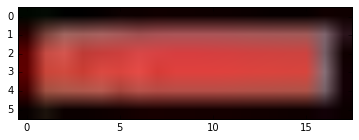

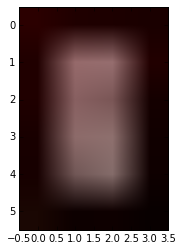

In [804]:
for p in mover_prototypes:
    plt.imshow(p)
    plt.show()

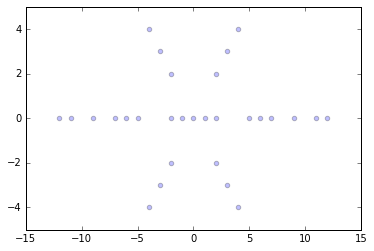

In [764]:
all_disps = reduce(lambda a,b: list(a)+list(b), mover_disps)
#all_disps_for_plot = [(d[0] + np.random.randn()/30,d[1]+np.random.randn()/30) for d in all_disps]
plt.scatter(*zip(*all_disps),alpha=0.25)

### class protoQnetwork below is adapted from https://github.com/awjuliani/DeepRL-Agents

Network architecture is similar to that in the 2014 DeepMind paper.  This version uses piaget's mover images to form a first layer of convolutional filters, and their observed displacements to form the second.

In [765]:
from nets import protoQnetwork, protoModelnetwork

### Some tests

In [766]:
tf.reset_default_graph()

h_size = 32

with tf.Session() as sess:
    qn = protoModelnetwork(env, h_size, mover_prototypes,\
                       mover_disps, md_equiv_classes, 5, 'qn')
    #qn2 = protoQnetwork(env, h_size, mover_prototypes, 'qn2')
    init = tf.global_variables_initializer()
    sess.run(init)
    print(sess.run(tf.shape(qn.conv2_model),feed_dict={qn.scalarInput:[s]}))

[  1 210 160  35]


## Training code below is adapted from https://github.com/awjuliani/DeepRL-Agents

### Experience Replay

In [17]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        self.reward_prop_frames = 6
        
    def add(self,experience,reward_prop):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        if reward_prop and len(self.buffer) > self.reward_prop_frames:
            for i in range(1,self.reward_prop_frames+1):
                self.buffer[-i][2] += 2**(-i)*experience[0,2]
        self.buffer.extend(experience)
            
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])
        #TESTING continguous samples -- this is dangerous!
        #start_index = random.randint(0,len(self.buffer)-size)
        #return np.array(myBuffer.buffer[start_index:start_index+128])

In [18]:
def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

Evaluated model
(526, 6.0)
Evaluated model
(156, 0.0)
(7329, 213.40000000000001, 1.0, 0.9985177000000488)


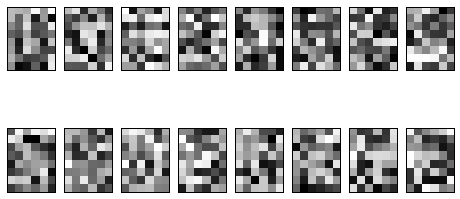

14
14
Evaluated model
(259, 2.0)
Evaluated model
(161, 0.0)
(9943, 219.40000000000001, 1.1000000000000001, 0.9965431000001138)


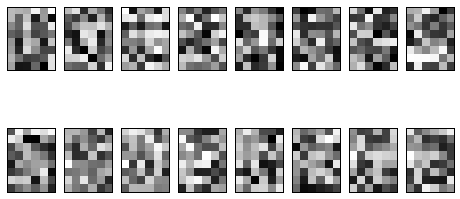

13
13
Evaluated model
(159, 0.0)
Evaluated model
(262, 2.0)
Evaluated model
(224, 1.0)
(12975, 238.69999999999999, 1.5, 0.9943948000001845)


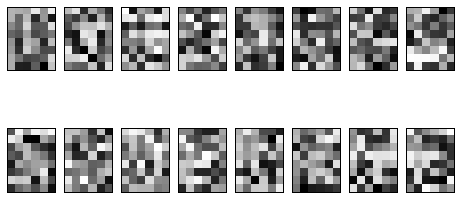

9
6
Evaluated model
(234, 1.0)
Evaluated model
(283, 2.0)
(16003, 251.09999999999999, 1.6000000000000001, 0.992134900000259)


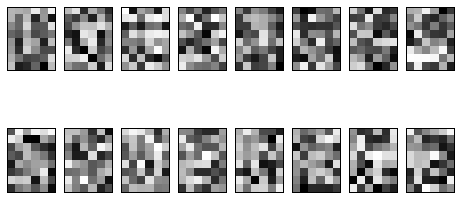

5
9
Evaluated model
(160, 0.0)


In [ ]:
tf.reset_default_graph()

mainQN = protoQnetwork(env, h_size, mover_prototypes, \
                       mover_disps, 3, 'mainQN', True,
                      lr=0.01, eps=1e-2)
targetQN = protoQnetwork(env, h_size, mover_prototypes, \
                       mover_disps, 3, 'targetQN', True)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

#targetOps = updateTargetGraph(trainables,tau)
targetOps = updateTargetGraph(trainables,1)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#statistics on Q
Qpred_list = []
Qtarget_list = []
QrList = []

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

sess = tf.Session()
#with tf.Session() as sess:
sess.run(init)
if load_model == True:
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)

updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
for i in range(num_episodes):
    episodeBuffer = experience_buffer()
    #Reset environment and get first new observation(s)
    s_list, r, d, info = initial_obs(env, breakout)
    s_stack = np.dstack(s_list)
    s = processState(s_stack)

    d = False
    rAll = 0
    j = 0

    # periodically evaluate
    if i % 5 == 0 and total_steps  > pre_train_steps:
        eval_episode = True
        saved_e = e
        e = 0.1
    else:
        eval_episode = False
    #The Q-Network
    while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
        j+=1
        
        #plt.imshow(env.render('rgb_array'))
        #plt.show()
        
        #Choose an action by greedily (with e chance of random action) from the Q-network
        if np.random.rand(1) < e or total_steps < pre_train_steps:
            a = np.random.randint(0,env.action_space.n)
        else:
            a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
        
        if breakout and np.array_equal(s_list[0],s_list[1]):
            # breakout: requesting next ball
            a = 1
        
        s_next,r,d,info = env.step(a)
        #s_next = cv2.cvtColor(s_next, cv2.COLOR_BGR2GRAY)

        s_list.pop(0)
        s_list.append(s_next)

        s_stack = np.dstack(s_list)
        s1 = processState(s_stack)

        total_steps += 1
        if (r > 0) or d:
            buffer_repeat = 1
        else:
            buffer_repeat = 1
        for dummy in range(buffer_repeat):
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]),reward_prop) #Save the experience to our episode buffer.

        if total_steps > pre_train_steps and not eval_episode:
            if e > endE:
                e -= stepDrop

            if total_steps % (update_freq) == 0:
                trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                #Below we perform the Double-DQN update to the target Q-values
                Q1 = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                end_multiplier = -(trainBatch[:,4] - 1)
                doubleQ = Q2[range(batch_size),Q1]
                targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                Qtarget_list.extend(targetQ)
                predQ = sess.run(mainQN.Q, \
                    feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), mainQN.actions:trainBatch[:,1]})
                Qpred_list.extend(predQ)
                QrList.extend(trainBatch[:,2])
                #Update the network with our target values.
                _ = sess.run(mainQN.updateModel, \
                    feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
                if (total_steps//update_freq) % reset_freq == 0:
                    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
#                 print('value')
#                 print(np.sum([sess.run(mainQN.streamV,\
#                  feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:1,0]), mainQN.actions:trainBatch[:1,1]})>0]))
#                 print(np.max(sess.run(mainQN.streamV,\
#                  feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:1,0]), mainQN.actions:trainBatch[:1,1]})))
#                 print('action')
#                 print(np.sum([sess.run(mainQN.streamA,\
#                  feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:1,0]), mainQN.actions:trainBatch[:1,1]})>0]))
#                 print(np.max(sess.run(mainQN.streamA,\
#                  feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:1,0]), mainQN.actions:trainBatch[:1,1]})))

        rAll += r
        s = s1

        if d == True:
            break
    #print(j)
    if not eval_episode:
        myBuffer.add(episodeBuffer.buffer,False)
        jList.append(j)
        rList.append(rAll)
    else:
        print("Evaluated model")
        print(j, rAll)
        e = saved_e
    #Periodically save the model. 
    if i % 100 == 0 and i > 0:
        saver.save(sess,path+'/model-'+str(i)+'.cptk')
        print("Saved Model")
    print_rate = 10
    if len(rList) % print_rate == 0 and total_steps > pre_train_steps:
        displayBatch = myBuffer.sample(1)
        
        print(total_steps,
              np.mean(jList[-print_rate:]),
              np.mean(rList[-print_rate:]), 
              e)
        all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        
#         test_weights=[v for v in all_vars \
#          if v.name == 'Conv/weights:0'][0]\
#         .eval(session=sess)
        
#         q_weights=[v for v in all_vars \
#          if v.name == 'Conv_1/weights:0'][0]\
#         .eval(session=sess)
        
        q_weights=[v for v in all_vars \
         if v.name == 'Conv/weights:0'][0]\
        .eval(session=sess)

        
        i_max=2
        j_max=8
        plt.figure(figsize=(8,4))
        for ii in range(i_max):
            for jj in range(j_max):
                cmap_max = max(np.max(q_weights[:,:,jj+(ii*j_max),0]),
                              -np.min(q_weights[:,:,jj+(ii*j_max),0]))
                plt.subplot(i_max,j_max,jj+(ii*j_max)+1)
                plt.xticks([])
                plt.yticks([])
                plt.imshow(q_weights[:,:,jj+(ii*j_max),0],cmap='gray',
                interpolation='nearest',
                vmin=-cmap_max,vmax=cmap_max)
        plt.show()
        
#         i_max=2
#         j_max=8
#         plt.figure(figsize=(8,2))
#         for ii in range(i_max):
#             for jj in range(j_max):
#                 cmap_max = max(np.max(test_weights[:,:,jj+(ii*j_max),-1]),
#                               -np.min(test_weights[:,:,jj+(ii*j_max),-1]))
#                 plt.subplot(i_max,j_max,jj+(ii*j_max)+1)
#                 plt.xticks([])
#                 plt.yticks([])
#                 plt.imshow(test_weights[:,:,jj+(ii*j_max),-1],cmap='gray',
#                 interpolation='nearest',
#                           vmin=-cmap_max,vmax=cmap_max)
                
#         plt.show()
        
        print(np.sum([sess.run(mainQN.streamV,\
            feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]), mainQN.actions:displayBatch[:,1]})>0]))
        print(np.sum([sess.run(mainQN.streamA,\
            feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]), mainQN.actions:displayBatch[:,1]})>0]))

saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

In [1044]:
from nets import protoQnetwork, protoModelnetwork

In [1046]:
batch_size = 32 #How many experiences to use for each training step.
update_freq = 4 #How often to perform a training step.
y = .75#.99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 1000000. #How many steps of training to reduce startE to endE.
num_episodes = 10000 #How many episodes of game environment to train network with.
max_epLength = 5000 #The max allowed length of our episode.
pre_train_steps = 5000 #How many steps of random actions before training begins.
load_model = False #Whether to load a saved model.
path = "./dqn/piaget" #The path to save our model to.
h_size = 64 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
#tau = 0.001 #Rate to update target network toward primary network
reset_freq = 500
reward_prop = True

act_repeat_len = 2
act_init_len = 4

(5571, 8.2060202611447917, 5.4833066203659504)
('action: ', 0)


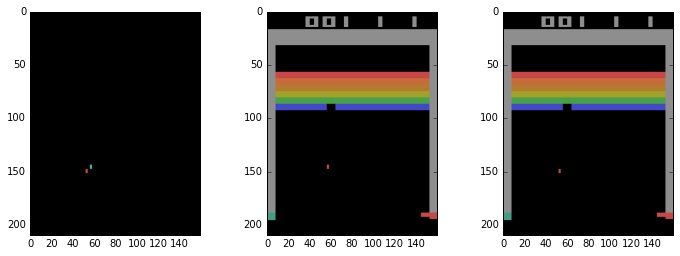

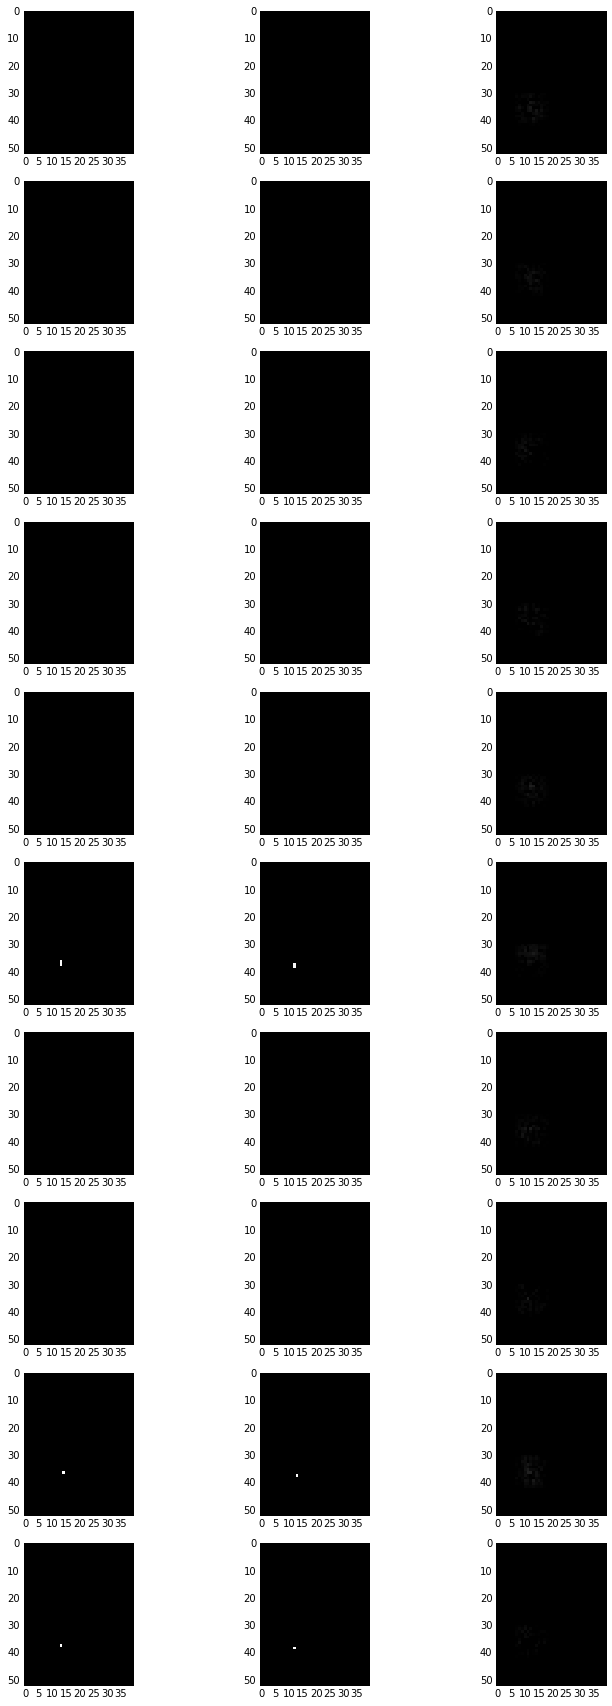

(6088, 8.1456683949214934, 5.4900632569235892)
('action: ', 2)


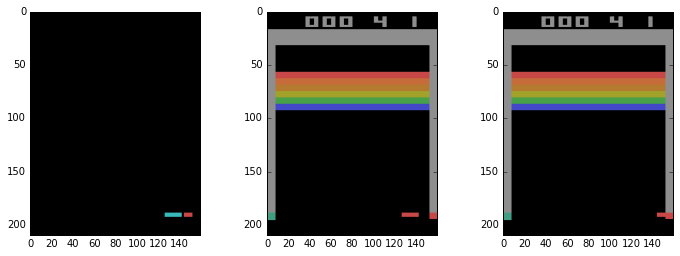

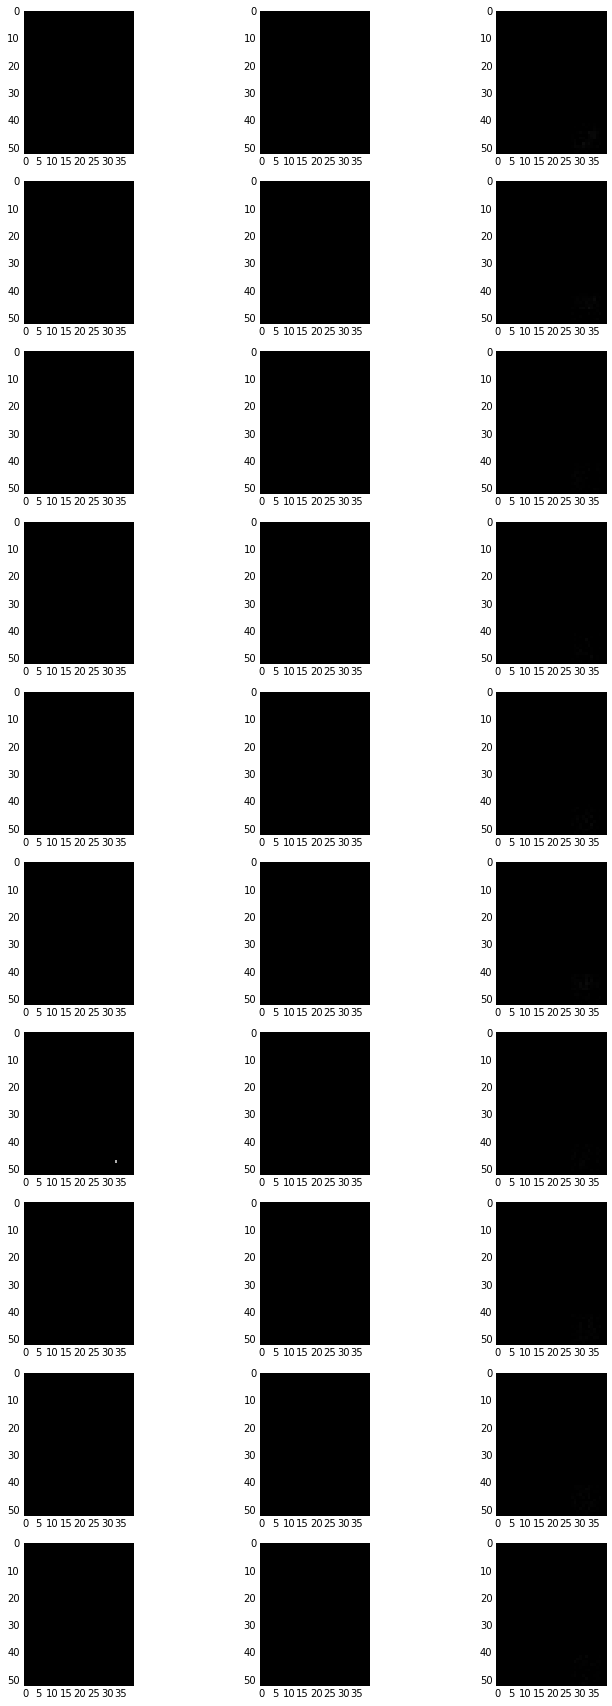

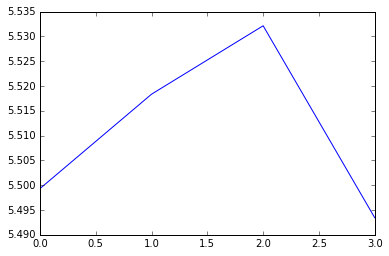

(6514, 8.1729363983495933, 5.4727906281012269)
('action: ', 1)


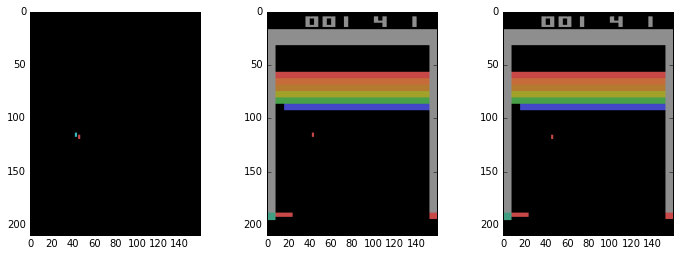

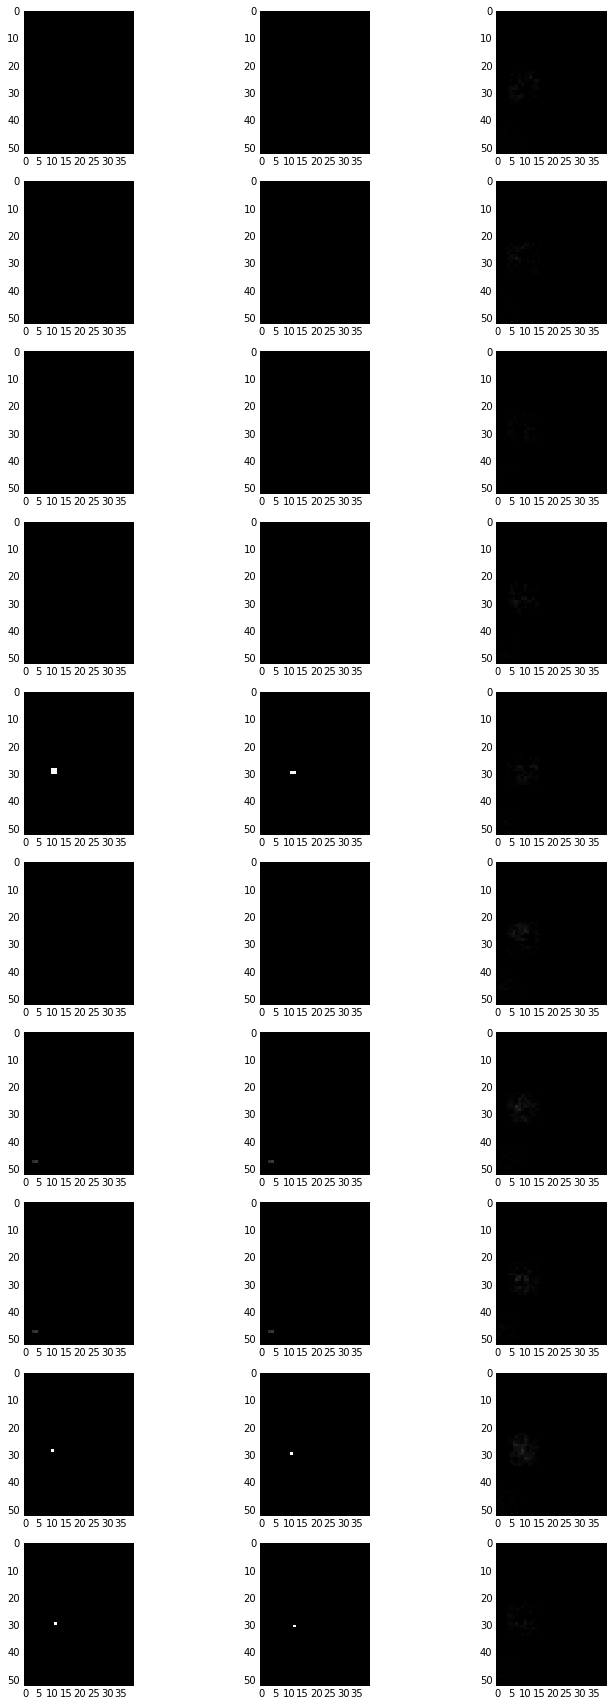

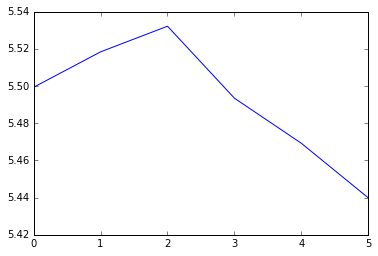

(7223, 8.1048850022836181, 5.4460937653562658)
('action: ', 0)


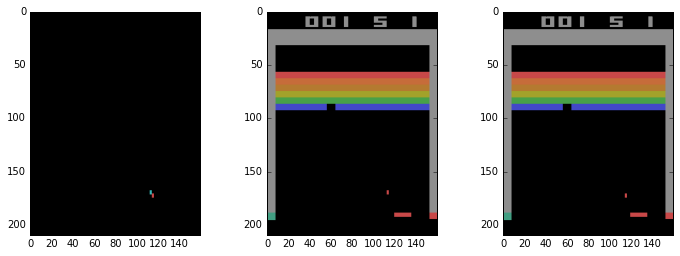

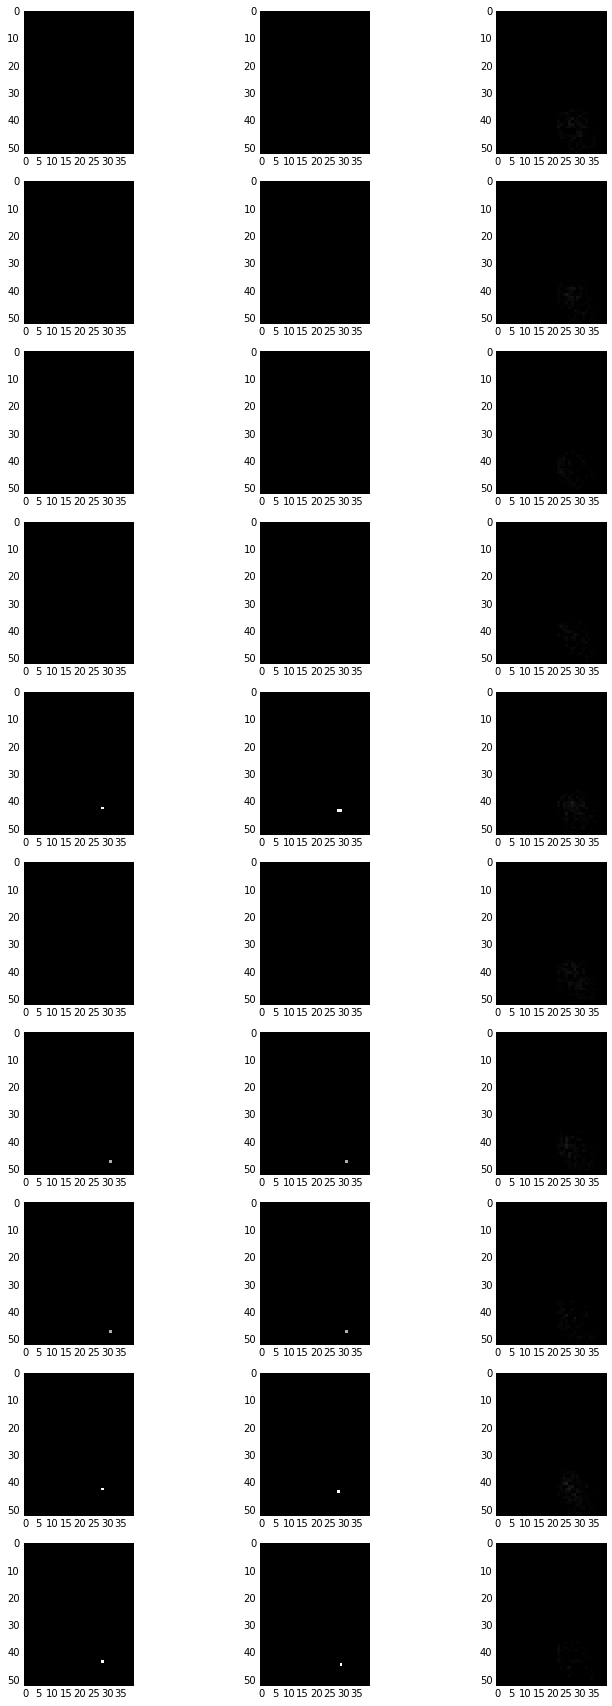

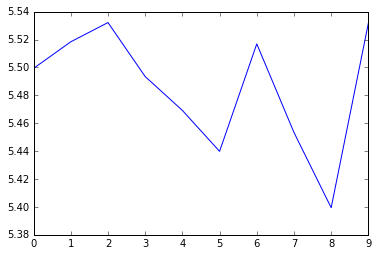

(7787, 8.211181770134429, 5.4501231415745091)
('action: ', 3)


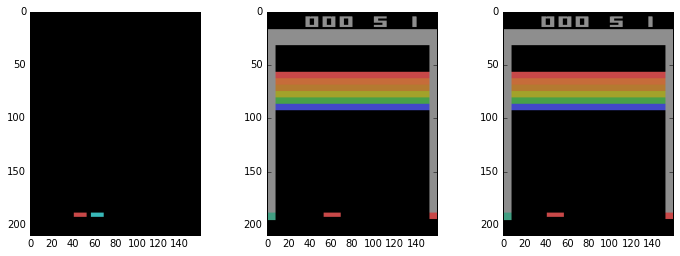

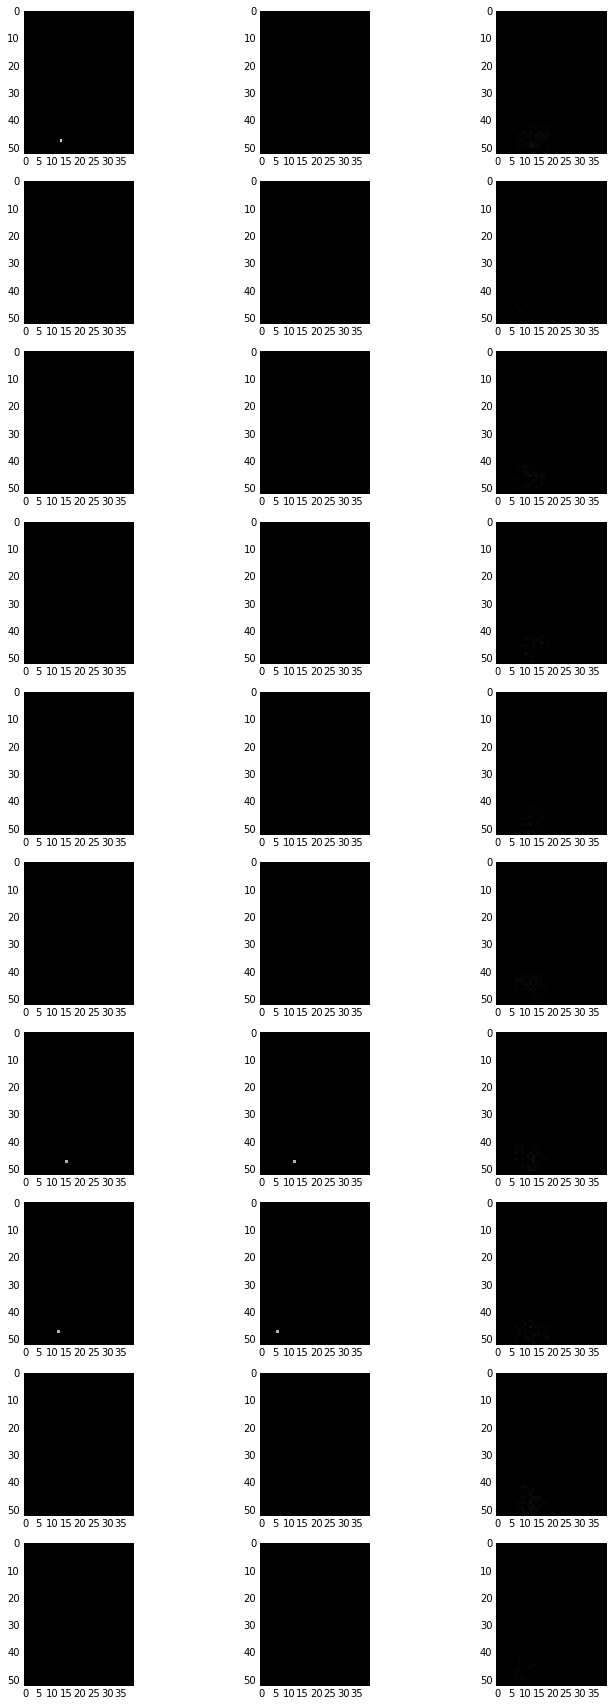

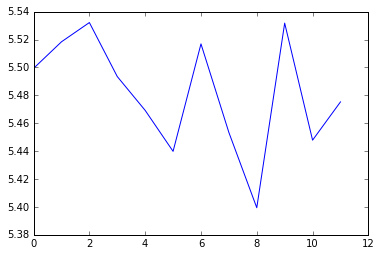

(8303, 8.0502205936715932, 5.3464827862019728)
('action: ', 2)


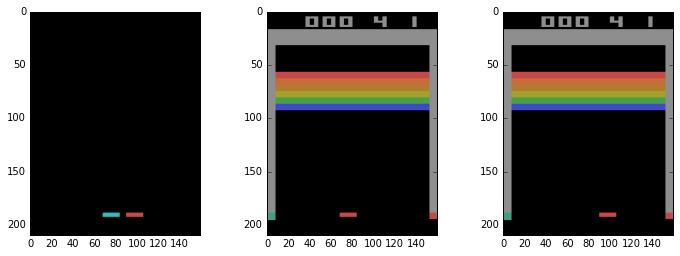

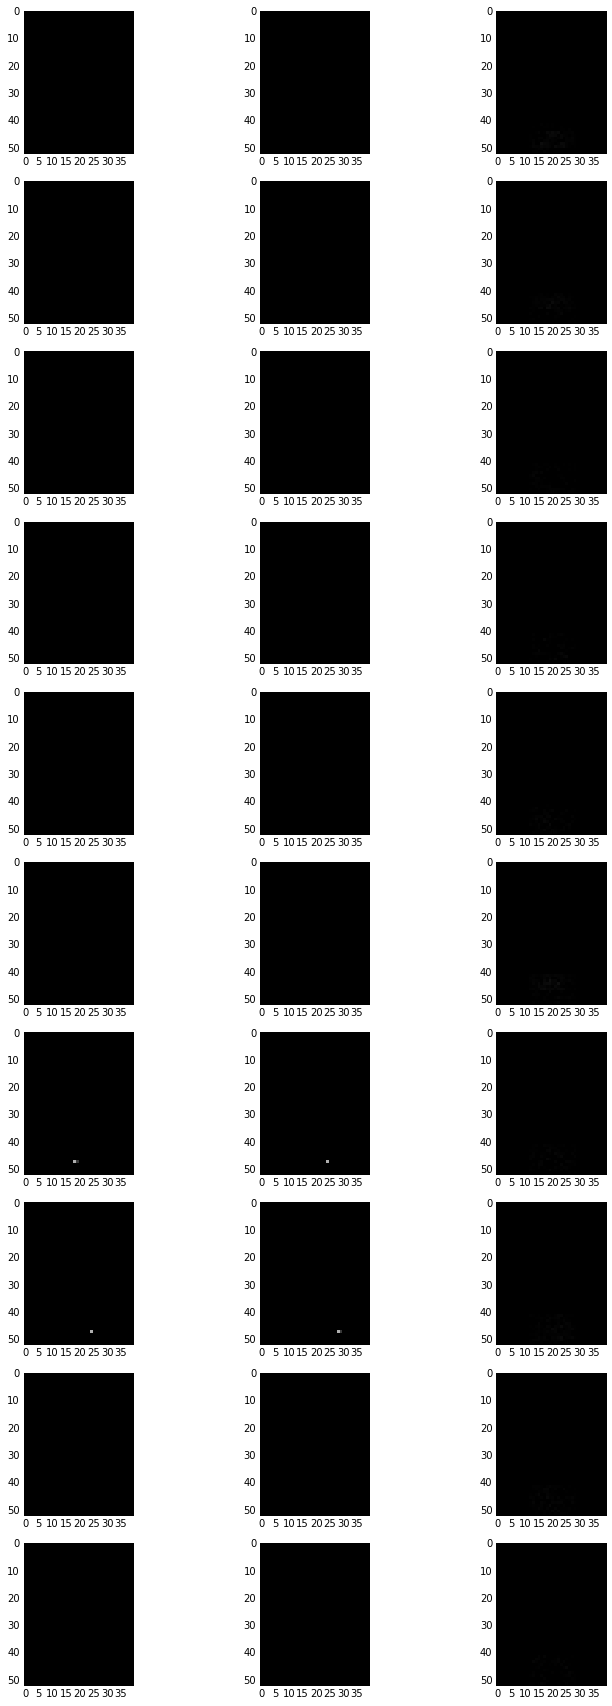

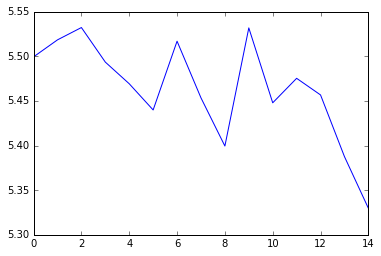

(8946, 8.1439004205879186, 5.4190974672595429)
('action: ', 3)


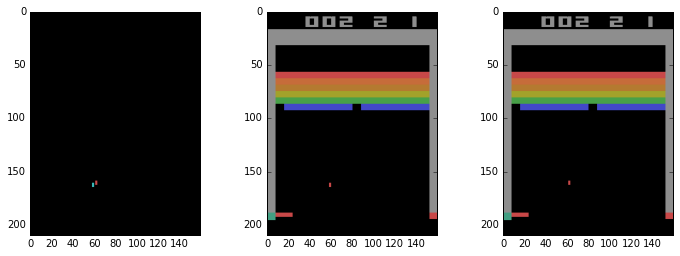

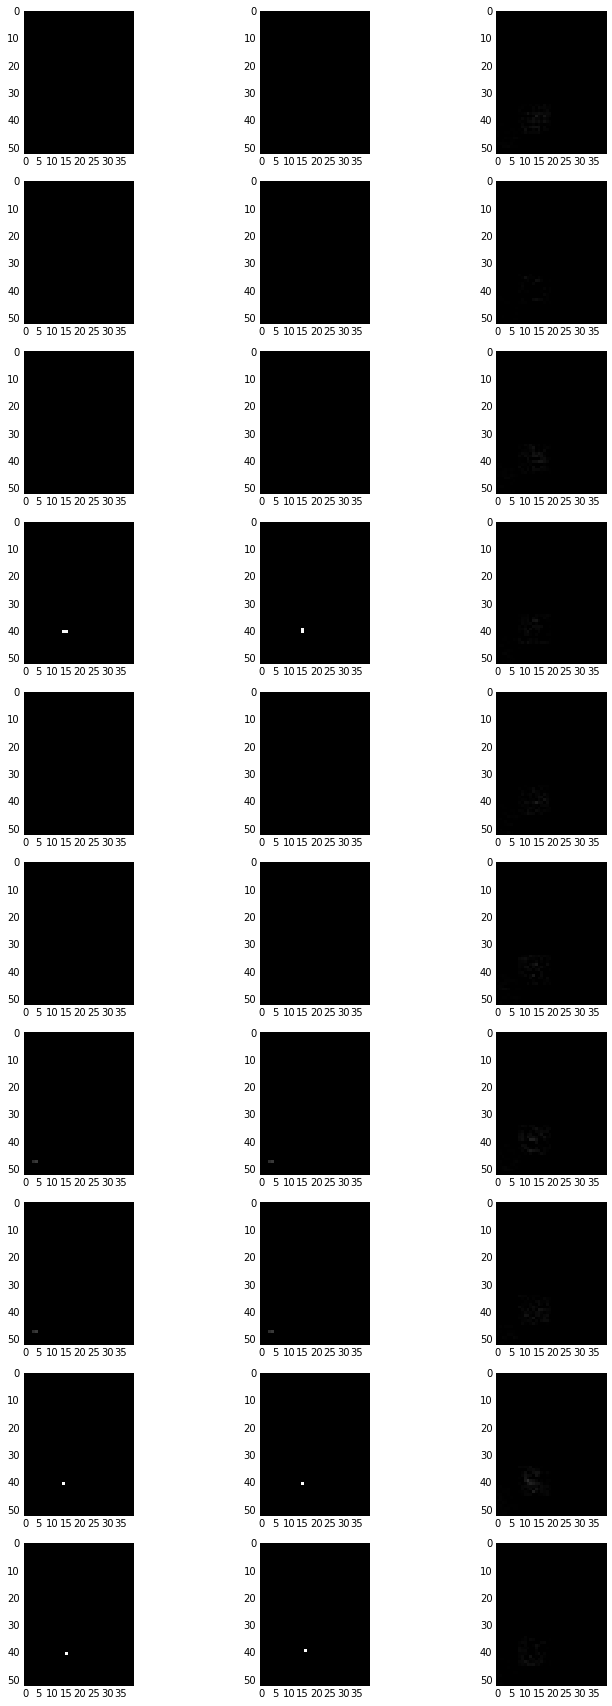

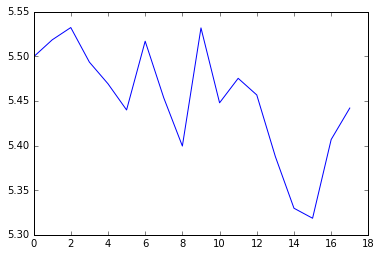

KeyboardInterrupt: 

In [1047]:
tf.reset_default_graph()

#trainables = tf.trainable_variables()

#targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#statistics on Q
Qpred_list = []
Qtarget_list = []
QrList = []

frame_err_list = []
reference_err_list = []
reward_err_list = []

mean_reward_pool = None

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

sess = tf.Session()
#with tf.Session() as sess:
if load_model == True:
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(path)
    saver.restore(sess,ckpt.model_checkpoint_path)

#updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
for i in range(num_episodes):
    episodeBuffer = experience_buffer()
    #Reset environment and get first new observation(s)
    s_list, r, d, info = initial_obs(env, breakout)
    s_stack = np.dstack(s_list)
    s = processState(s_stack)

    d = False
    rAll = 0
    j = 0

    # periodically evaluate
    if False:#i % 5 == 0 and total_steps  > pre_train_steps:
        eval_episode = True
        saved_e = e
        e = 0.1
    else:
        eval_episode = False
    
    act_repeat_countdown = 0
    
    while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
        j+=1
        
        save_to_buffer = True
                        
        if breakout and np.array_equal(s_list[0],s_list[1]):
            # breakout: requesting next ball
            a = 1
            save_to_buffer = False
        elif act_repeat_countdown == 0:
            a = np.random.randint(0,env.action_space.n)
            for _ in range(act_init_len):
                s_next,r,d,info = env.step(a)
                s_list.pop(0)
                s_list.append(s_next)
                s_stack = np.dstack(s_list)
                s = processState(s_stack)
            act_repeat_countdown = act_repeat_len
        else:
            act_repeat_countdown -= 1

        s_next,r,d,info = env.step(a)

        s_list.pop(0)
        s_list.append(s_next)

        s_stack = np.dstack(s_list)
        s1 = processState(s_stack)

        total_steps += 1
        if (r > 0) or d:
            buffer_repeat = 1
        else:
            buffer_repeat = 1
        if save_to_buffer:
            for dummy in range(buffer_repeat):
                episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]),reward_prop) #Save the experience to our episode buffer.

        if total_steps > pre_train_steps and not eval_episode:
            if mean_reward_pool is None:
                
                bootstrapQN = protoModelnetwork(env, h_size, mover_prototypes, \
                       mover_disps, md_equiv_classes, 5, 'bootstrapQN', dueling=True,
                          lr=0.001, eps=1e-3, mean_reward_pool=None)
                init = tf.global_variables_initializer()
                sess.run(init)

                reward_frames = [f[3] for f in myBuffer.buffer if f[2]>0.5]
                reward_pools = sess.run(bootstrapQN.conv_dm_pool,feed_dict={bootstrapQN.scalarInput:reward_frames})

                mean_reward_pool = np.mean(reward_pools,axis=0)

#                 mainQN = protoModelnetwork(env, h_size, mover_prototypes, \
#                        mover_disps, 3, 'mainQN', dueling=True,
#                           lr=0.01, eps=1e-5, mean_reward_pool=mean_reward_pool)
                mainQN = protoModelnetwork(env, h_size, mover_prototypes, \
                         mover_disps, md_equiv_classes, 3, 'mainQN', dueling=True,
                            lr=0.01, eps=1e-8, mean_reward_pool=None)

                init = tf.global_variables_initializer()
                sess.run(init)

                saver = tf.train.Saver()
                
            if e > endE:
                e -= stepDrop

            if total_steps % (update_freq) == 0:
                trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                target_pool = sess.run(mainQN.cdp_equiv,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
#                 for ch_ind in range(len(all_disps_neg)):
#                     target_pool[:,:,:,ch_ind] = np.roll(target_pool[:,:,:,ch_ind],\
#                                                        (0,)+all_disps_neg[ch_ind])
                pred_pool = sess.run(mainQN.pred_pool,\
                                     feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), mainQN.actions:trainBatch[:,1]})
                previous_pool = sess.run(mainQN.cdp_equiv,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0])})
                
                frame_err_list.append(sum(((target_pool-pred_pool)**2).flatten()))
                reference_err_list.append(sum(((target_pool-previous_pool)**2).flatten()))
                #update_ops = [mainQN.reward_loss, mainQN.updateModel, mainQN.reward_updateModel]
                update_ops = [mainQN.updateModel]
                (_) = \
                sess.run(update_ops, \
                    feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]),
                               mainQN.target_pool:target_pool, 
                               mainQN.actions:trainBatch[:,1]})
                #reward_err_list.append(reward_loss)

        rAll += r
        s = s1

        if d == True:
            break
    #print(j)
    if not eval_episode:
        myBuffer.add(episodeBuffer.buffer,False)
        jList.append(j)
        rList.append(rAll)
    else:
        print("Evaluated model")
        print(j, rAll)
        e = saved_e
    #Periodically save the model. 
    if i % 100 == 0 and i > 0:
        saver.save(sess,path+'/model-'+str(i)+'.cptk')
        print("Saved Model")
    print_rate = 5
    if len(rList) % print_rate == 0 and total_steps > pre_train_steps:
        for _ in range(1):
            displayBatch = myBuffer.sample(1)
            target_pool = sess.run(mainQN.cdp_equiv,feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,3])})
            pred_pool = sess.run(mainQN.pred_pool,\
                                 feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]), mainQN.actions:displayBatch[:,1]})
            previous_pool = sess.run(mainQN.cdp_equiv,feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0])})

            print(total_steps, np.mean(reference_err_list[-100:]), np.mean(frame_err_list[-100:]))
            print('action: ', displayBatch[0][1])

            plt.figure(figsize=(12,4))
            s0 = np.reshape(displayBatch[0,0],(210,160,6))
            plt.subplot(131)
            plt.imshow(s0[:,:,3:] - s0[:,:,:3])
            plt.subplot(132)
            plt.imshow(s0[:,:,:3])
            plt.subplot(133)
            plt.imshow(s0[:,:,3:])
            i_max = target_pool.shape[3]
            plt.figure(figsize=(12,3*i_max))
            j_max = 3
            for ii in range(i_max):
                for jj in range(j_max//3):
                    #plt.subplot(i_max,2*j_max,jj+(ii*j_max)+1)
                    #plt.xticks([])
                    #plt.yticks([])
                    target_img = target_pool[0,:,:,ii]
                    pred_img = pred_pool[0,:,:,ii]
                    previous_img = previous_pool[0,:,:,ii]

                    #cmap_max = max(np.max(previous_img), np.max(target_img))
                    #cmap_min = min(np.min(previous_img), np.min(target_img))
                    cmap_max = 0.2; cmap_min = 0
                    
                    plt.subplot(i_max,j_max,3*jj+(ii*j_max)+1)
                    plt.imshow(previous_img,cmap='gray',interpolation='nearest',
                              vmin=cmap_min, vmax=cmap_max)
                    plt.subplot(i_max,j_max,3*jj+(ii*j_max)+2)
                    plt.imshow(target_img,cmap='gray',interpolation='nearest',
                              vmin=cmap_min, vmax=cmap_max)
                    plt.subplot(i_max,j_max,3*jj+(ii*j_max)+3)
                    plt.imshow(pred_img,cmap='gray',interpolation='nearest',
                              vmin=cmap_min, vmax=cmap_max)
                    #print(np.max(previous_img),np.max(target_img),np.max(pred_img))
            plt.show()

        
        avg_window = 50
        if len(frame_err_list) > 3*avg_window:
            plt.figure()

            sqMat = np.resize(np.array(frame_err_list),[len(frame_err_list)//avg_window,avg_window])
            QsqAvgs = np.average(sqMat,1)
            plt.plot(QsqAvgs[1:])
            plt.show()
            
saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

In [905]:
mover_disps[0]

[(-5, 0),
 (9, 0),
 (7, 0),
 (-2, 0),
 (-11, 0),
 (12, 0),
 (-6, 0),
 (6, 0),
 (-12, 0),
 (11, 0),
 (2, 0),
 (-7, 0),
 (-9, 0),
 (5, 0),
 (1, 0),
 (-1, 0)]

In [863]:
m_id_shift = 0
for m_id, m_eq in enumerate(md_equiv_classes):
    for eq in m_eq:
        print [all_disps[m_id_shift + d_id] for d_id in eq]
        print ''
m_id_shift += len(mover_disps[m_id])

[(-5, 0), (-2, 0), (-11, 0), (-6, 0), (-12, 0), (-7, 0), (-9, 0), (-1, 0)]

[(9, 0), (7, 0), (12, 0), (6, 0), (11, 0), (2, 0), (5, 0), (1, 0)]

[(2, 0), (-7, 0), (-11, 0)]

[(-12, 0), (9, 0), (-2, 0)]

[(11, 0), (7, 0), (-6, 0)]

[(-5, 0), (12, 0), (6, 0)]



In [862]:
for m_id, m_eq in enumerate(md_equiv_classes):
    for eq in m_eq:
        print [mover_disps[m_id][d_id] for d_id in eq]
        print ''

[(-5, 0), (-2, 0), (-11, 0), (-6, 0), (-12, 0), (-7, 0), (-9, 0), (-1, 0)]

[(9, 0), (7, 0), (12, 0), (6, 0), (11, 0), (2, 0), (5, 0), (1, 0)]

[(-4, -4), (-3, -3), (-2, -2)]

[(2, -2), (4, -4), (3, -3)]

[(2, 2), (3, 3), (4, 4)]

[(-3, 3), (-2, 2), (-4, 4)]



In [858]:
tf.trainable_variables()[len(tf.trainable_variables())//2:][6]

<tf.Variable 'mainQN/piaget/mover_disps/mover0/disp1/kernel:0' shape=(1, 10, 2, 1) dtype=float32_ref>

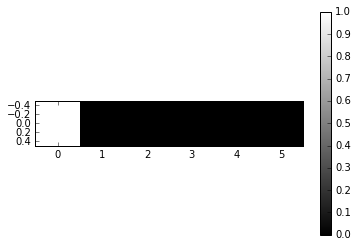

In [860]:
plt.imshow(tf.trainable_variables()[len(tf.trainable_variables())//2:][4]\
           [:,:,1,0].eval(session=sess),cmap='gray',interpolation='nearest')
plt.colorbar()

In [ ]:
print md_equiv_classes[1]
print mover_disps[1]

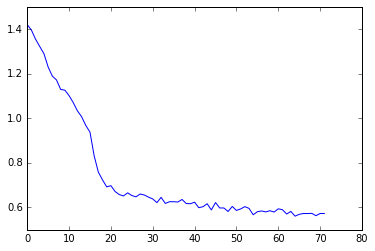

In [617]:
sqMat = np.resize(np.array(frame_err_list),[len(frame_err_list)//avg_window,avg_window])
QsqAvgs = np.average(sqMat,1)
plt.plot(QsqAvgs[1:])
plt.show()

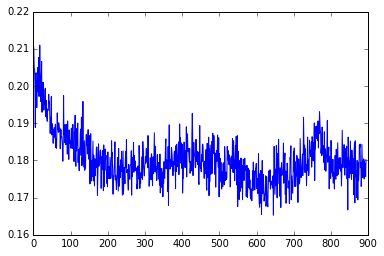

In [586]:
sqMat = np.resize(np.array(frame_err_list),[len(frame_err_list)//avg_window,avg_window])
QsqAvgs = np.average(sqMat,1)
plt.plot(QsqAvgs[1:])
plt.show()

In [283]:
def get_position_filters(axis, reps):
    filter0 = np.zeros(mainQN.out_shape,dtype='float32')
    filter1 = np.zeros(mainQN.out_shape,dtype='float32')

    if axis == 1:
        filter0 = filter0.T
        filter1 = filter1.T

    len_to_fill = filter0.shape[0]
    len_per_band = len_to_fill // reps
    
    for ii in range(len_to_fill):
        if (ii // len_per_band) % 2 == 0:
            filter0[ii,:] = 1.
        else:
            filter1[ii,:] = 1.
    
    if axis == 1:
        filter0 = filter0.T
        filter1 = filter1.T

    return filter0, filter1

In [328]:
test = tf.zeros_like(mainQN.conv_dm_pool[:,...,0]) + tf.convert_to_tensor(filter0)

test2 = tf.stack([test,test],3)

tf.concat([mainQN.conv_dm_pool, test2],3)

<tf.Tensor 'concat_10:0' shape=(?, 52, 40, 18) dtype=float32>

In [329]:
mainQN.mover_conv_list

[<tf.Tensor 'mainQN/piaget/prototypes/proto0/Relu:0' shape=(?, 210, 160, 2) dtype=float32>,
 <tf.Tensor 'mainQN/piaget/prototypes/proto1/Relu:0' shape=(?, 210, 160, 2) dtype=float32>]

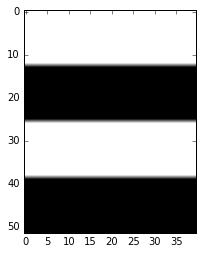

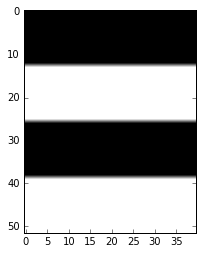

In [287]:
filter0, filter1 = get_position_filters(0,4)
plt.imshow(filter0, cmap='gray')
plt.show()
plt.imshow(filter1, cmap='gray')
plt.show()

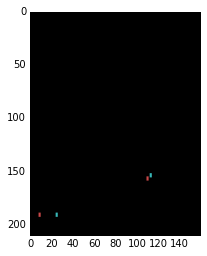

In [956]:
trainBatch = myBuffer.sample(1)

plt.imshow(np.reshape(trainBatch[0][0],(210,160,6))[:,:,3:] -
           np.reshape(trainBatch[0][0],(210,160,6))[:,:,:3])

In [957]:
l1 = sess.run(mainQN.conv_movers,feed_dict={mainQN.scalarInput: [trainBatch[0][0]]})[0]
l2 = sess.run(mainQN.conv_disps,feed_dict={mainQN.scalarInput: [trainBatch[0][0]]})[0]
l_equiv = sess.run(mainQN.cdp_equiv,feed_dict={mainQN.scalarInput: [trainBatch[0][0]]})[0]

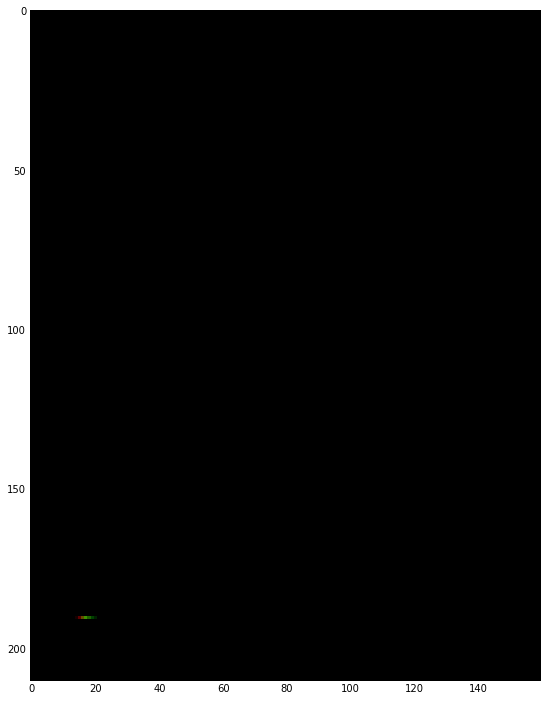

In [958]:
plt.figure(figsize=(12,12))
l1_img = 2*np.stack([l1[:,:,1],l1[:,:,0],np.zeros_like(l1[:,:,0])],2)
plt.imshow(l1_img,interpolation='nearest')

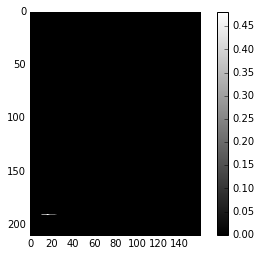

In [960]:
plt.imshow(l_equiv[:,:,0],cmap='gray',interpolation='nearest')
plt.colorbar()

In [955]:
mover_disps[0]

[(-5, 0),
 (9, 0),
 (7, 0),
 (-2, 0),
 (-11, 0),
 (12, 0),
 (-6, 0),
 (6, 0),
 (-12, 0),
 (11, 0),
 (2, 0),
 (-7, 0),
 (-9, 0),
 (5, 0),
 (1, 0),
 (-1, 0)]

In [880]:
#init = tf.global_variables_initializer()
#sess.run(init)
act_frames = sess.run(mainQN.act_frames,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), mainQN.actions:trainBatch[:,1]})
mainQN.get_Q(act_frames)

AttributeError: protoModelnetwork instance has no attribute 'act_frames'

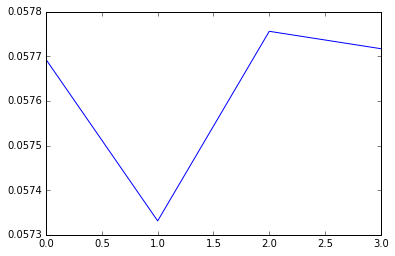

In [158]:
plt.plot(mainQN.Qout[0]);

[2017-06-03 19:58:43,394] Making new env: Breakout-v0


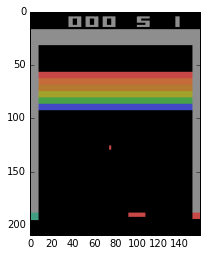

action: 0
0
0


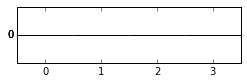

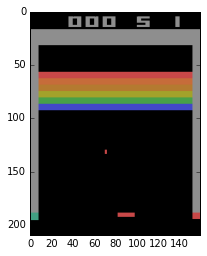

action: 0
0
0


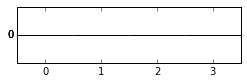

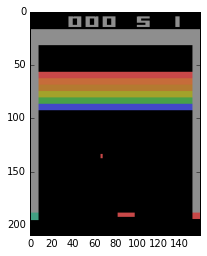

action: 0
0
0


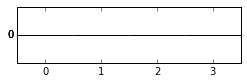

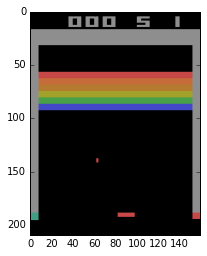

action: 0
0
0


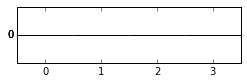

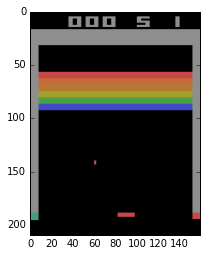

action: 0
0
0


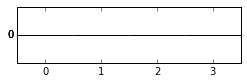

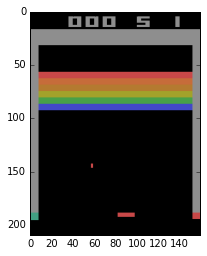

action: 0
0
0


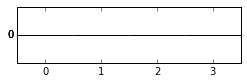

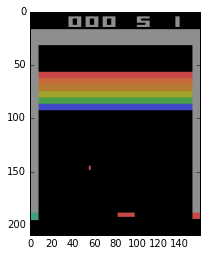

action: 0
0
0


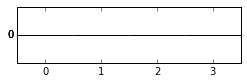

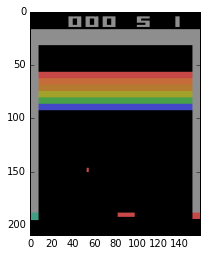

action: 0
0
0


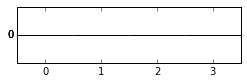

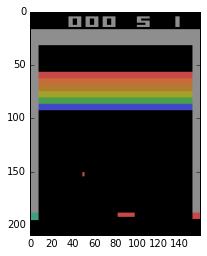

action: 0
0
0


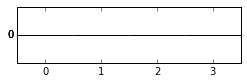

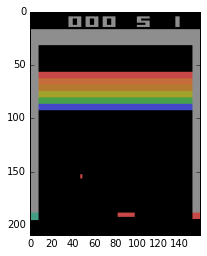

action: 0
0
0


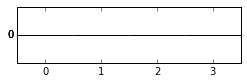

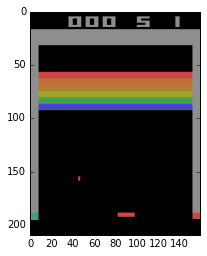

action: 0
0
0


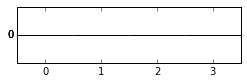

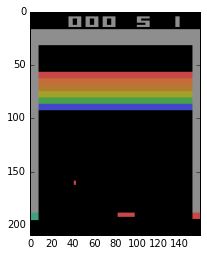

action: 0
0
0


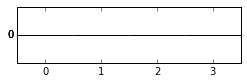

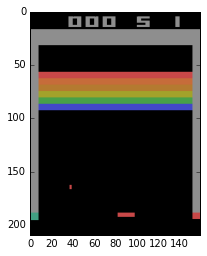

action: 0
0
0


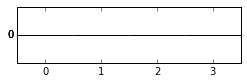

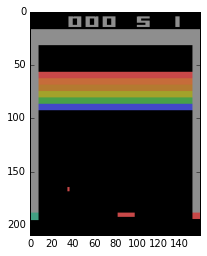

action: 0
0
0


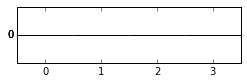

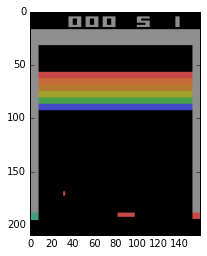

action: 0
0
0


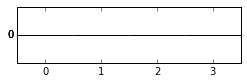

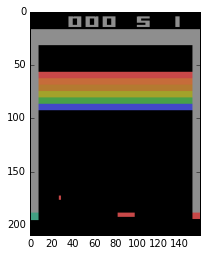

action: 0
0
0


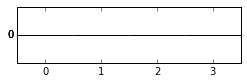

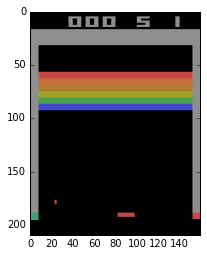

action: 0
0
0


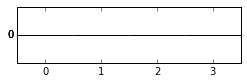

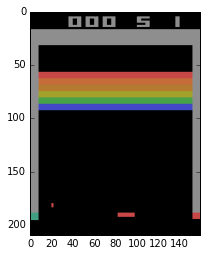

action: 0
2
0


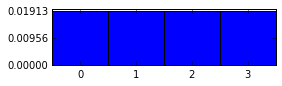

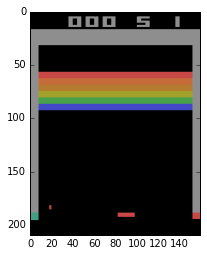

action: 0
2
0


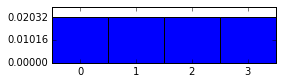

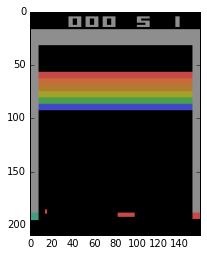

action: 0
2
0


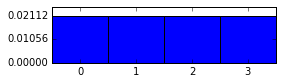

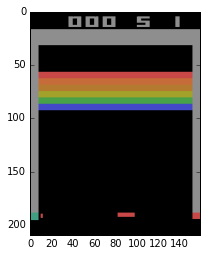

action: 0
2
0


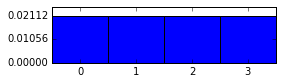

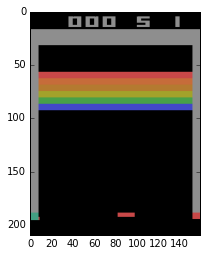

action: 0
3
1


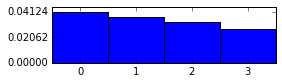

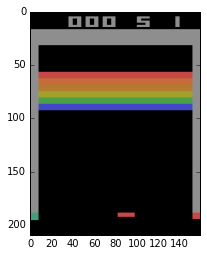

action: 0
3
1


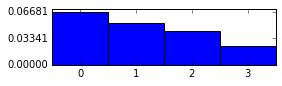

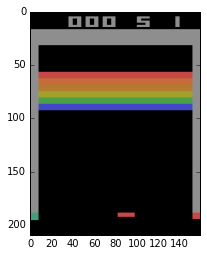

action: 0
3
1


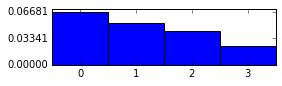

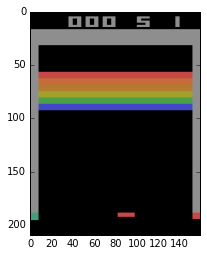

action: 0
3
1


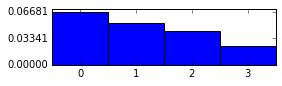

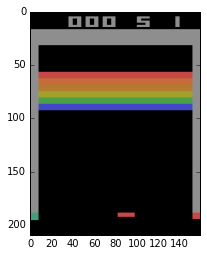

action: 0
3
1


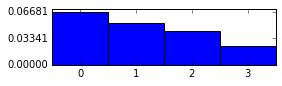

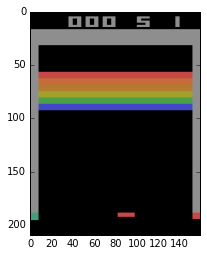

action: 0
3
1


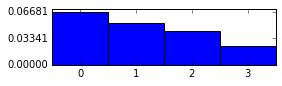

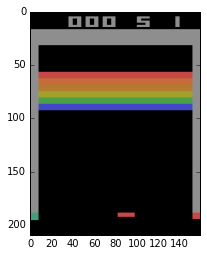

action: 0
3
1


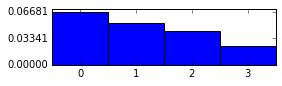

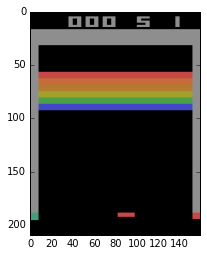

action: 0
3
1


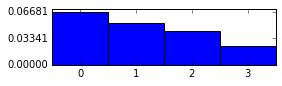

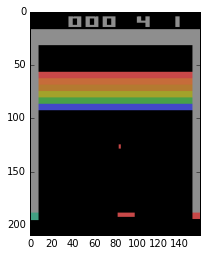

action: 0
1
0


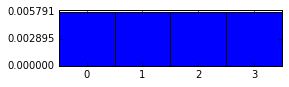

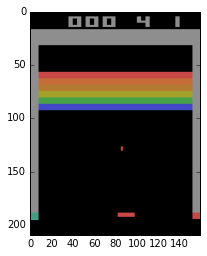

action: 0
0
0


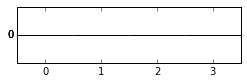

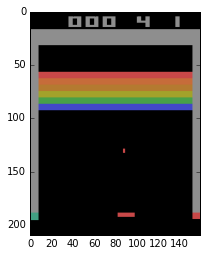

action: 0
0
0


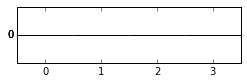

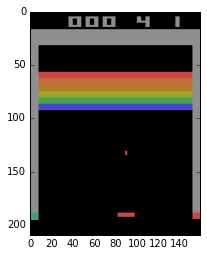

action: 0
0
0


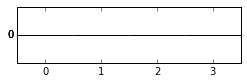

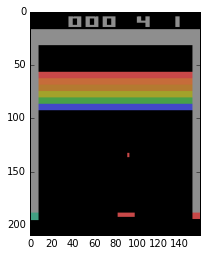

action: 0
0
0


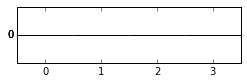

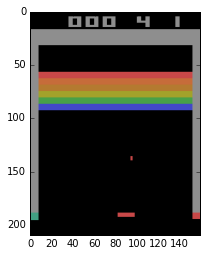

action: 0
0
0


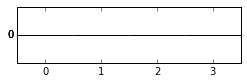

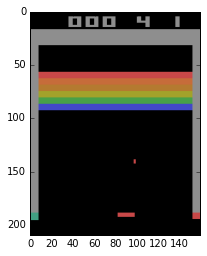

action: 0
0
0


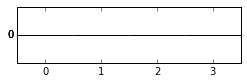

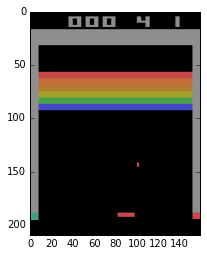

action: 0
0
0


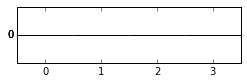

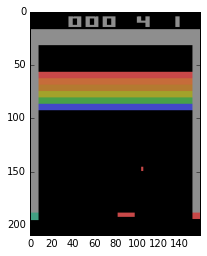

action: 0
0
0


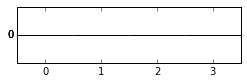

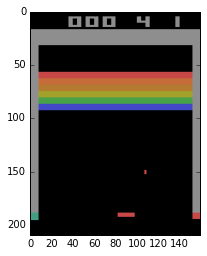

action: 0
0
0


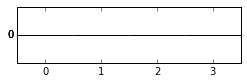

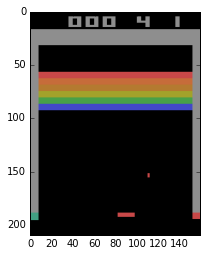

action: 0
0
0


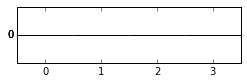

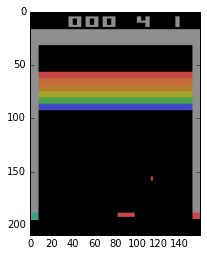

action: 0
0
0


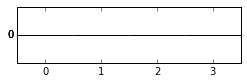

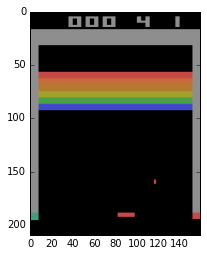

action: 0
0
0


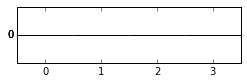

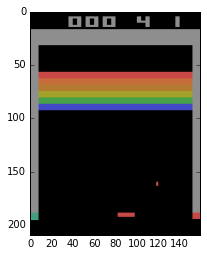

action: 0
0
0


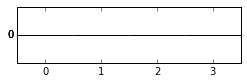

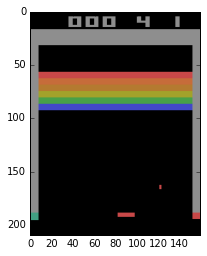

action: 0
0
0


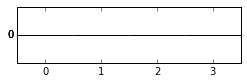

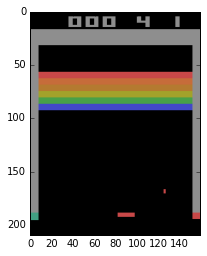

action: 0
0
0


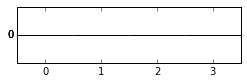

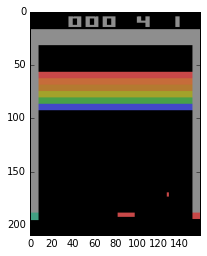

action: 0
2
0


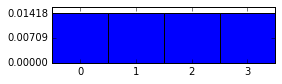

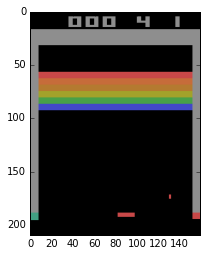

action: 0
2
0


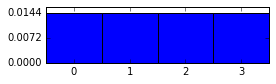

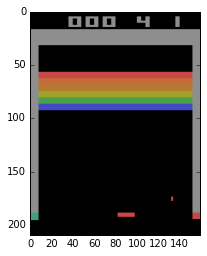

action: 0
2
0


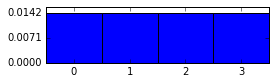

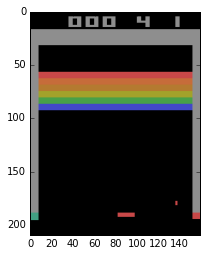

action: 0
2
0


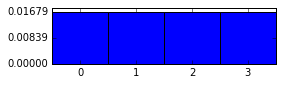

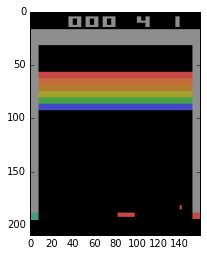

action: 0
2
0


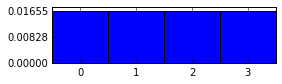

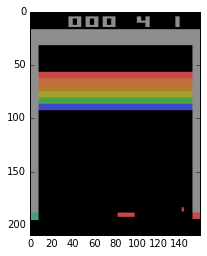

action: 0
2
0


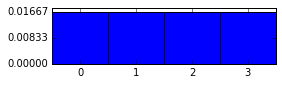

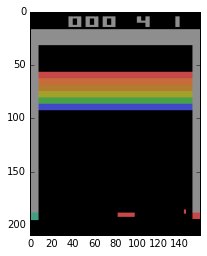

action: 0
2
0


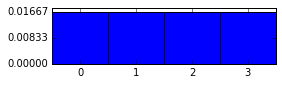

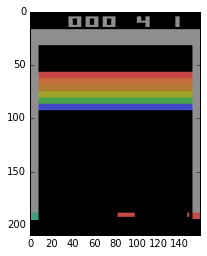

action: 0
2
0


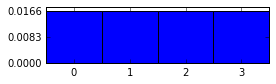

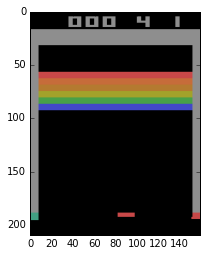

action: 0
2
0


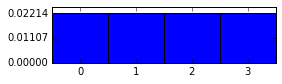

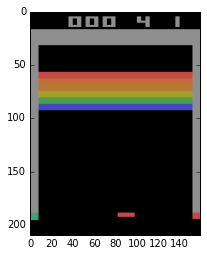

action: 0
3
1


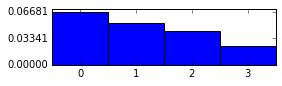

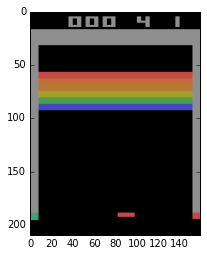

action: 0
3
1


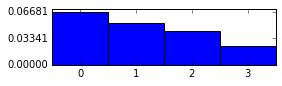

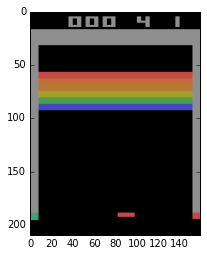

action: 0
3
1


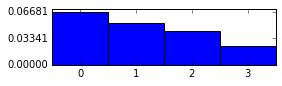

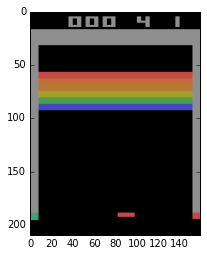

action: 0
3
1


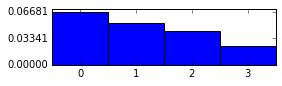

q


In [204]:
env = gym.make(env_title)
s_list, r, d, info = initial_obs(env, breakout)
s_stack = np.dstack(s_list)
s = processState(s_stack)


d = False
rAll = 0
j = 0

e = 0

while j < max_epLength:
    j+=1

    plt.figure()
    plt.imshow(s_stack[:,:,3:])
    plt.show()

    #Choose an action by greedily (with e chance of random action) from the Q-network
    if np.random.rand(1) < e or total_steps < pre_train_steps:
        a = np.random.randint(0,env.action_space.n)
        print 'random action: ' + str(a)
    else:
#         act_frames = sess.run(mainQN.act_frames,feed_dict={mainQN.scalarInput:[s]})
#         mainQN.get_Q(act_frames)
#         Qout = mainQN.Qout[0]
#         a = mainQN.predict[0]
        a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
        print 'action: ' + str(a)
    if np.array_equal(s_list[0],s_list[1]):
        a = 1
    
    Qout = sess.run(mainQN.Qout,feed_dict={mainQN.scalarInput:[s]})[0]
    Qout_target = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:[s]})[0]
    print(np.sum([sess.run(mainQN.streamV,feed_dict={mainQN.scalarInput:[s]})>0]))
    print(np.sum([sess.run(mainQN.streamA,feed_dict={mainQN.scalarInput:[s]})>0]))
    if True:#np.var(Qout) > 0:
        plt.figure(figsize=(4,1))
        plt.bar(np.arange(4)-0.5,Qout,width=1)
        plt.xticks(range(4));
        plt.yticks(np.linspace(0,max(Qout),3));
        plt.show()
        if j%1 == 0:
            if raw_input() == 'q':
                break

    
    s_next,r,d,info = env.step(a)
    
    
    s_list.pop(0)
    s_list.append(s_next)

    s_stack = np.dstack(s_list)
    s1 = processState(s_stack)

    rAll += r
    s = s1

    if d == True:
        break

In [910]:
sess.run(mainQN.streamA,\
         feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]), mainQN.actions:displayBatch[:,1]})

array([[ 0.        ,  0.        ,  0.        ,  0.00067102,  0.04917433,
         0.        ,  0.        ,  0.        ,  0.02195593,  0.        ,
         0.0250507 ,  0.00795321,  0.02916563,  0.01147852,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.09755917,
         0.        ,  0.        ,  0.        ,  0.02563024,  0.        ,
         0.        ,  0.03858812,  0.00206866,  0.        ,  0.03718561,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.04855313,  0.03562154,
         0.00140339,  0.        ,  0.        ,  0.01872141,  0.        ,
         0.03155626,  0.        ,  0.        ,  0.05205956,  0.        ,
         0.        ],
       [ 0.01677665,  0.02403419,  0.        ,  0.        ,  0.03196315,
         0.        ,  0.        ,  0.        ,  0.04861519,  0.        ,
         0.        ,  0.03577914,  0.        ,  0.04531803,  0.        ,
         0.02614394],
       [ 0.        ,  0.        ,  0

In [ ]:
testBatch = myBuffer.sample(500)
reward_preds = sess.run(mainQN.pred_reward, feed_dict={mainQN.scalarInput:np.vstack(testBatch[:,0]),
                               mainQN.actions:testBatch[:,1],
                               mainQN.target_reward:testBatch[:,2]})

(array([ 8.33333333,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 0.  ,  0.12,  0.24,  0.36,  0.48,  0.6 ,  0.72,  0.84,  0.96,
         1.08,  1.2 ]),
 <a list of 10 Patch objects>)

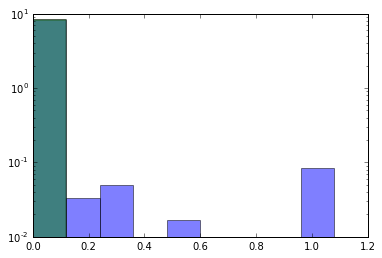

In [304]:
plt.hist(testBatch[:,2],normed=True,log=True,range=(0,1.2),alpha=0.5)
plt.hist(reward_preds,normed=True,log=True,range=(0,1.2),alpha=0.5)

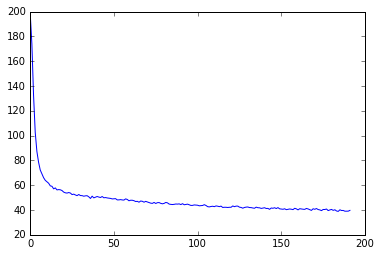

In [299]:
avg_window = 100

sqMat = np.resize(np.array(frame_err_list),[len(frame_err_list)//avg_window,avg_window])
QsqAvgs = np.average(sqMat,1)
plt.plot(QsqAvgs)

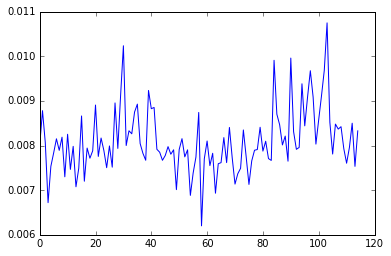

In [272]:
avg_window = 1000

sqMat = np.resize(np.array(reward_err_list),[len(reward_err_list)//avg_window,avg_window])
QsqAvgs = np.average(sqMat,1)
plt.plot(QsqAvgs)

In [595]:
displayBatch = myBuffer.sample(1000)
target_pool = sess.run(mainQN.cdp_equiv,feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,3])})
pred_pool = sess.run(mainQN.pred_pool,\
                     feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]), mainQN.actions:displayBatch[:,1]})
previous_pool = sess.run(mainQN.cdp_equiv,feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0])})

pred_V = sess.run(mainQN.streamV,\
                     feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]), mainQN.actions:displayBatch[:,1]})
pred_A = sess.run(tf.einsum('abcde,ae->abcd',mainQN.streamA,mainQN.actions_onehot),\
                     feed_dict={mainQN.scalarInput:np.vstack(displayBatch[:,0]), mainQN.actions:displayBatch[:,1]})



actions = displayBatch[:,1]

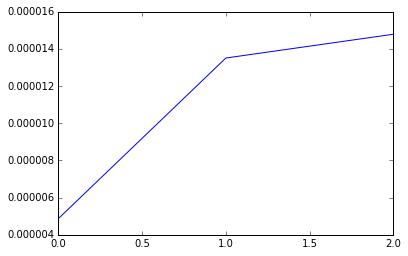

In [596]:
errs = np.mean((target_pool-pred_pool)**2,(1,2))
errs_batch_mean = np.mean(errs,0)
plt.plot(errs_batch_mean)

In [597]:
import pandas as pd
df = pd.DataFrame(errs)
df['actions'] = actions

df.groupby('actions').mean()

,0,1,2
actions,,,
0,8.232856e-07,0.000015,0.000016
1,5.072305e-07,0.000012,0.000013
2,6.665843e-06,0.000014,0.000015
3,1.325006e-05,0.000013,0.000015


In [598]:
sort_inds0, sort_inds1 = np.unravel_index(np.argsort(errs,None),errs.shape)
sort_inds0 = sort_inds0[::-1]
sort_inds1 = sort_inds1[::-1]

all_disps = reduce(lambda a,b: list(a)+list(b), mover_disps)

2
0


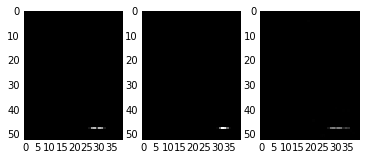

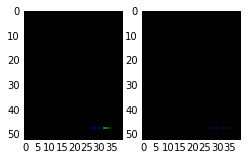

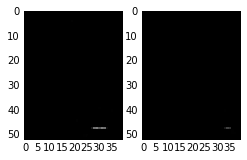

3
0


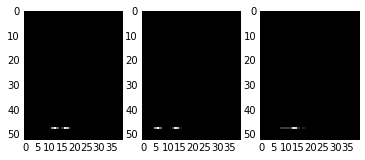

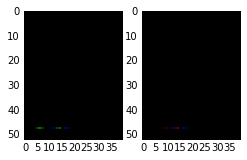

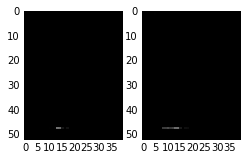

3
0


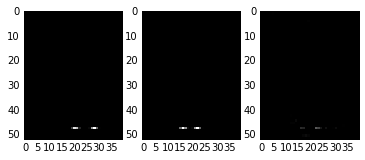

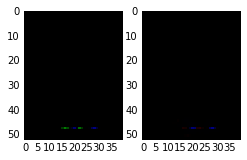

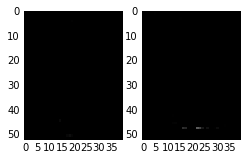

3
2


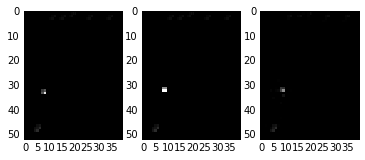

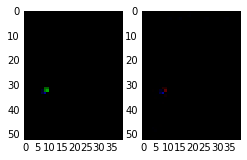

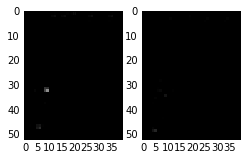

2
0


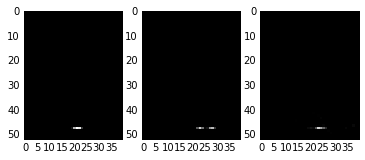

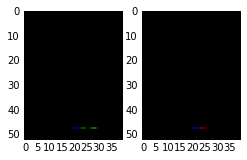

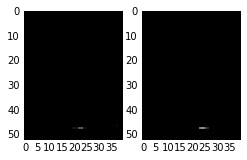

3
0


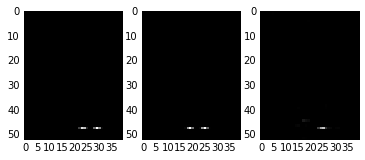

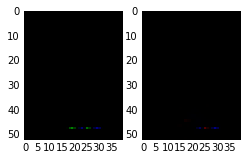

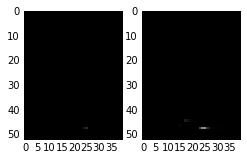

3
2


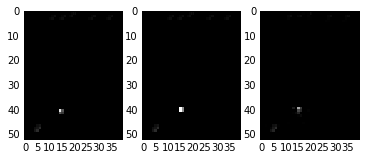

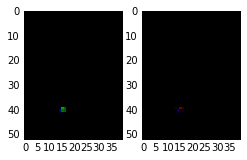

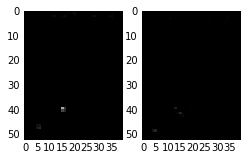

2
0


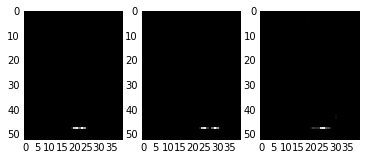

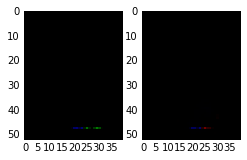

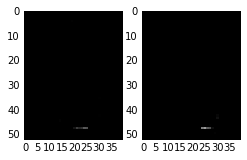

2
0


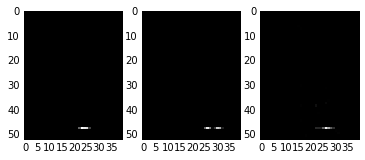

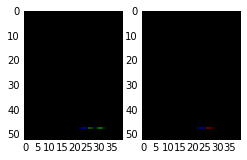

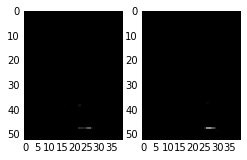

2
0


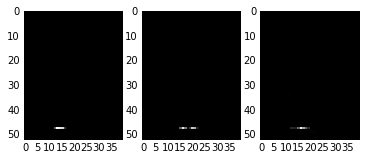

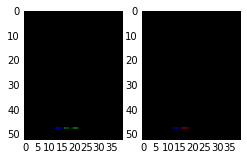

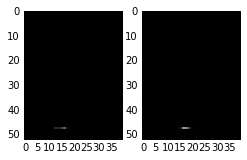

In [600]:
for ind in range(10):
    print(actions[sort_inds0[ind]])
    if sort_inds1[ind] <= 12:
        #print(all_disps[sort_inds1[ind]])
        print(sort_inds1[ind])
    
    previous_img = previous_pool[sort_inds0[ind],:,:,sort_inds1[ind]]
    target_img = target_pool[sort_inds0[ind],:,:,sort_inds1[ind]]
    pred_img = pred_pool[sort_inds0[ind],:,:,sort_inds1[ind]]
    
    V_img = pred_V[sort_inds0[ind],:,:,sort_inds1[ind]]
    A_img = pred_A[sort_inds0[ind],:,:,sort_inds1[ind]]
    
    cmap_max = max(np.max(previous_img), np.max(target_img))
    cmap_min = min(np.min(previous_img), np.min(target_img))

    plt.subplot(131)
    plt.imshow(previous_img,cmap='gray',interpolation='nearest',vmin=cmap_min,
              vmax=cmap_max)
    plt.subplot(132)
    plt.imshow(target_img,cmap='gray',interpolation='nearest',vmin=cmap_min,
              vmax=cmap_max)
    plt.subplot(133)
    plt.imshow(pred_img,cmap='gray',interpolation='nearest',vmin=cmap_min,
              vmax=cmap_max)
    plt.show()
    
    plt.subplot(131)
    tgpv = 2*(target_img-previous_img)*(target_img > previous_img).astype('float32')
    tlpv = 2*(previous_img-target_img)*(target_img < previous_img).astype('float32')
    vis_img = np.stack(
             [np.zeros_like(previous_img), tgpv, tlpv],2)
    plt.imshow(vis_img,interpolation='nearest')
    plt.subplot(132)
    pgpv = 2*(pred_img-previous_img)*(pred_img > previous_img).astype('float32')
    plpv = 2*(previous_img-pred_img)*(pred_img < previous_img).astype('float32')
    vis_img = np.stack(
             [pgpv, np.zeros_like(previous_img), plpv],2)
    plt.imshow(vis_img,interpolation='nearest')

    plt.show()
    
    plt.subplot(132)
    plt.imshow(V_img,cmap='gray',interpolation='nearest',vmin=cmap_min,
              vmax=cmap_max)
    plt.subplot(133)
    plt.imshow(A_img,cmap='gray',interpolation='nearest',vmin=cmap_min,
              vmax=cmap_max)
    plt.show()


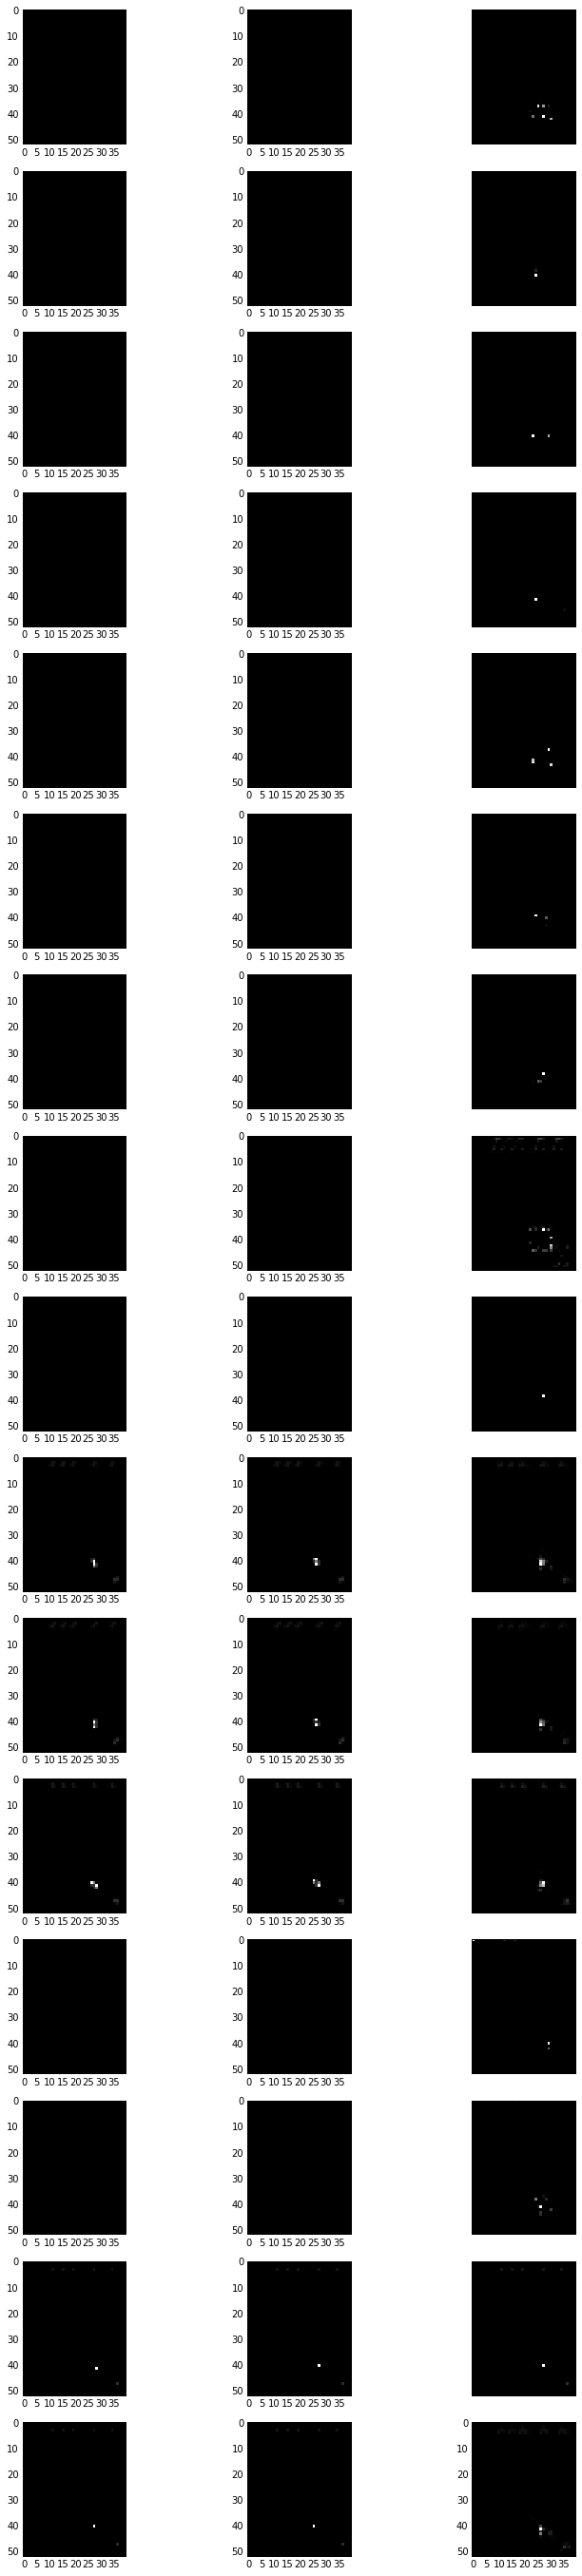

In [1031]:
plt.figure(figsize=(12,48))
i_max = 16
j_max = 3
for ii in range(i_max):
    for jj in range(j_max//3):
        #plt.subplot(i_max,2*j_max,jj+(ii*j_max)+1)
        plt.xticks([])
        plt.yticks([])
        target_img = target_pool[0,:,:,ii]
        pred_img = pred_pool[0,:,:,ii]
        previous_img = previous_pool[0,:,:,ii]
        pred_img = (pred_img + np.abs(pred_img)) / 2
        diff = target_img - pred_img
        tgp = np.abs(target_img)*(target_img>0)*(pred_img<=0)#(np.abs(diff) + diff)/2
        tlp = np.abs(pred_img)*(target_img<=0)*(pred_img>0)#(np.abs(diff) - diff)/2
        agreement = ((1-np.abs(target_img-pred_img))*(target_img>0)*(pred_img>0))#(target_img+pred_img)/2.
#         vis_img = (1.*np.stack([tlp, tgp, agreement],2))
#         plt.imshow(vis_img,interpolation='nearest')
        plt.subplot(i_max,j_max,3*jj+(ii*j_max)+1)
        vis_img = np.stack(
             [np.zeros_like(previous_img), np.zeros_like(previous_img), previous_img],2)
        plt.imshow(previous_img,cmap='gray',interpolation='nearest')
        plt.subplot(i_max,j_max,3*jj+(ii*j_max)+2)
        vis_img = np.stack(
             [np.zeros_like(target_img), target_img, np.zeros_like(target_img)],2)
        plt.imshow(target_img,cmap='gray',interpolation='nearest')
        plt.subplot(i_max,j_max,3*jj+(ii*j_max)+3)
        vis_img = np.stack(
             [pred_img, np.zeros_like(pred_img), np.zeros_like(pred_img)],2)
        plt.imshow(pred_img,cmap='gray',interpolation='nearest')
plt.show()


In [445]:
reward_frames = [f[3] for f in myBuffer.buffer if f[2]>0.5]
reward_pools = sess.run(mainQN.conv_dm_pool,feed_dict={mainQN.scalarInput:reward_frames})

mean_reward_pool = np.mean(reward_pools,axis=0)

non_reward_frames = [f[3] for f in myBuffer.buffer if f[2]<0.6][115:125]
non_reward_pools = sess.run(mainQN.conv_dm_pool,feed_dict={mainQN.scalarInput:non_reward_frames})

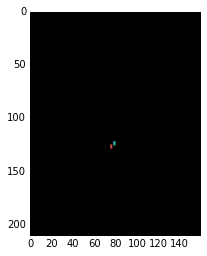

(-5, 0)


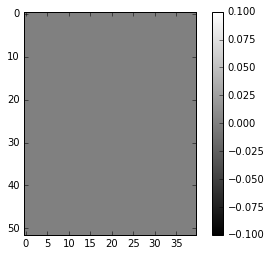

(9, 0)


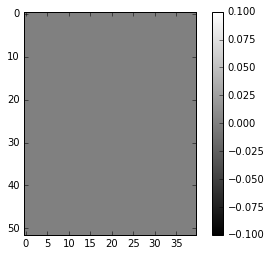

(0, 0)


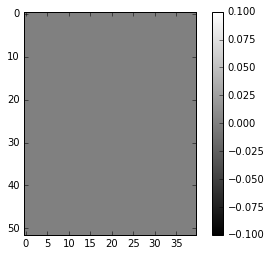

(7, 0)


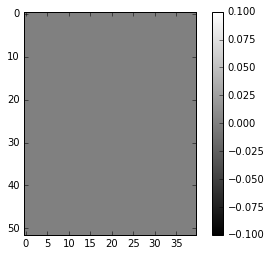

(-2, 0)


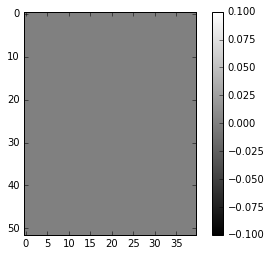

(-11, 0)


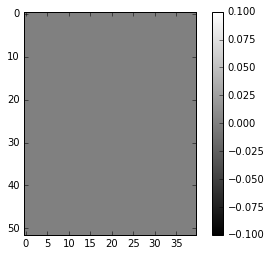

(12, 0)


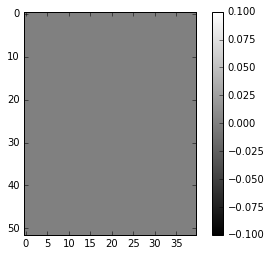

(-6, 0)


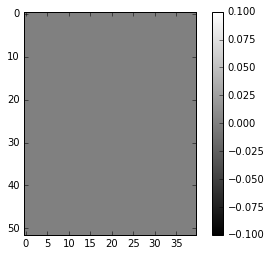

(1, 0)


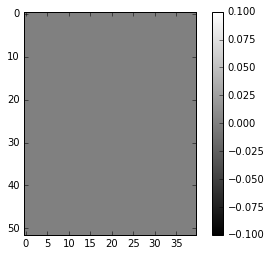

(-3, 3)


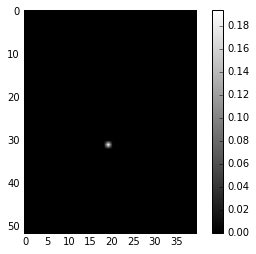

(-4, 4)


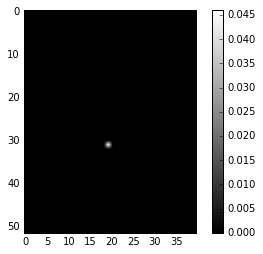

(2, 2)


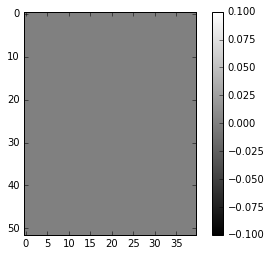

In [453]:
f = non_reward_frames[1]
plt.imshow(np.reshape(f,(210,160,6))[:,:,3:]-np.reshape(f,(210,160,6))[:,:,:3])
plt.show()
for ch_ind in range(12):
    print all_disps[ch_ind]
    plt.imshow(non_reward_pools[1][:,:,ch_ind],cmap='gray')
    plt.colorbar()
    plt.show()

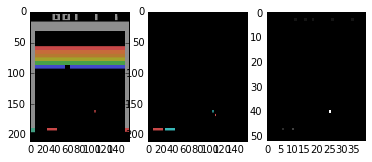

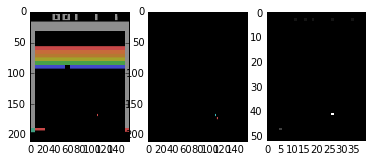

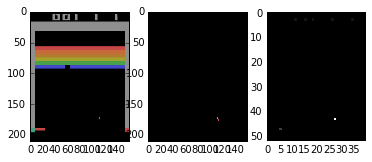

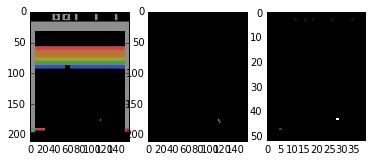

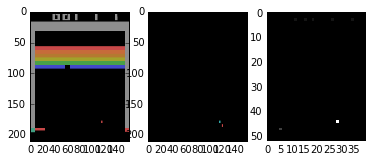

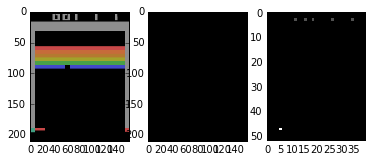

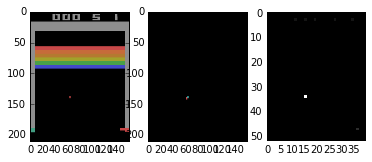

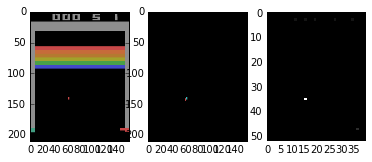

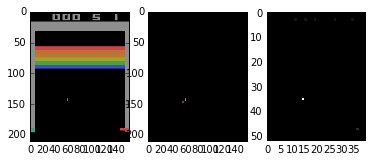

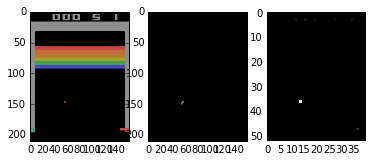

In [433]:
for f, pool in zip(non_reward_frames, non_reward_pools):
    plt.subplot(131)
    plt.imshow(np.reshape(f,(210,160,6))[:,:,:3])
    plt.subplot(132)
    plt.imshow(np.reshape(f,(210,160,6))[:,:,3:]-np.reshape(f,(210,160,6))[:,:,:3])
    plt.subplot(133)
    plt.imshow(pool[:,:,-2],cmap='gray', interpolation='nearest')
    plt.show()

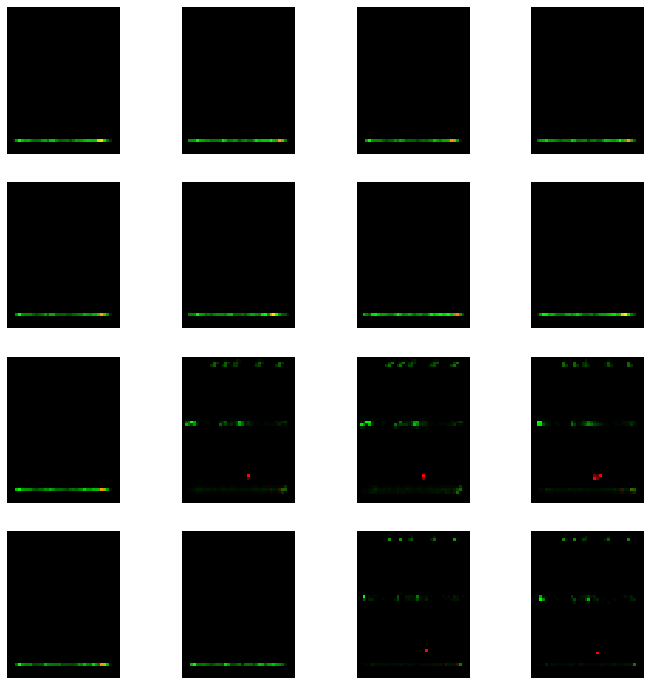

In [1158]:
plt.figure(figsize=(12,12))
i_max = 4
j_max = 4
for ii in range(i_max):
    for jj in range(j_max):
        plt.subplot(i_max,j_max,jj+(ii*j_max)+1)
        plt.xticks([])
        plt.yticks([])
        ch0 = non_reward_pools[0][:,:,jj+(ii*j_max)]
        ch1 = mean_reward_pool[:,:,jj+(ii*j_max)]
        
        if np.max(ch0) > 0:
            ch0 = ch0 / np.max(ch0)
        if np.max(ch1) > 0:
            ch1 = ch1 / np.max(ch1)
            
        vis_img = np.stack([ch0, ch1,
                  np.zeros_like(ch0)],2)

        #vis_img = (vis_img > 0).astype('float32')
        plt.imshow(vis_img, interpolation='nearest')
plt.show()

In [1152]:
x_coords = np.array([[j for j in range(40)] for i in range(52)])
y_coords = np.array([[i for j in range(40)] for i in range(52)])

x_flat = np.reshape(x_coords,(52*40,))
y_flat = np.reshape(y_coords,(52*40,))
coords_flat = [[x,y] for x, y in zip(x_flat, y_flat)]

dists = distance_matrix(coords_flat,coords_flat)
dists = np.asarray(dists, order='C')

In [44]:
test=np.zeros((5,5,5,5))
test[:,...,0].shape

(5, 5, 5)

In [1211]:
ch_dists = np.zeros((10,16))
start_index = 0

for f_ind in range(10):
    for ii in range(start_index,16):
        demand = np.asarray(np.reshape(mean_reward_pool[:,:,ii], (52*40,)).astype('float64'), order='C')

        supply = np.asarray(np.reshape(non_reward_pools[f_ind][:,:,ii], (52*40,)).astype('float64'), order='C')
        
        if min(np.sum(demand), np.sum(supply)) > 0:
            demand = demand / np.sum(demand)
            supply = supply / np.sum(supply)

            ch_dists[f_ind, ii-start_index] = pyemd.emd(supply, demand, dists)

In [1212]:
for jj in range(ch_dists.shape[1]):
    for ii in range(ch_dists.shape[0]):
        if ch_dists[ii,jj] == 0:
            ch_dists[ii,jj] = np.mean(ch_dists[:,jj][ch_dists[:,jj] > 0])

In [1213]:
ch_dists

array([[ 12.87229567,  12.78212569,  12.93780308,  12.85030202,
         12.84565956,  12.88327515,  12.56757058,  13.02539156,
         12.96242313,  14.85618359,  15.26092944,  15.88967421,
         13.07956944,  13.09409468,  15.59735507,  15.10561764],
       [ 12.87229567,  12.78212569,  12.93780308,  12.85030202,
         12.84565956,  12.88327515,  12.56757058,  13.02539156,
         12.96242313,  14.18070138,  13.81898886,  16.42902207,
         13.07956944,  13.09409468,  14.89366705,  14.75136397],
       [ 15.85949685,  14.3335012 ,  15.28453767,  14.51945408,
         15.40867098,  16.41293647,  13.91338464,  16.04920297,
         15.24111011,  14.00055791,  13.55668937,  14.39545793,
         13.07956944,  15.59017417,  14.60190981,  15.16689896],
       [ 15.01483974,  14.95707408,  15.07734739,  15.106797  ,
         14.95399149,  14.88170679,  15.02429008,  15.20439452,
         15.09787999,  15.15238115,  14.14919074,  15.50813298,
         15.05122402,  15.20973847,  

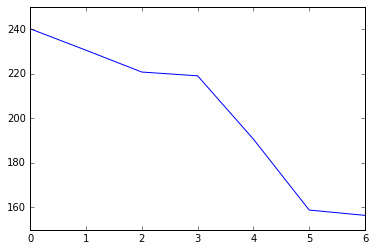

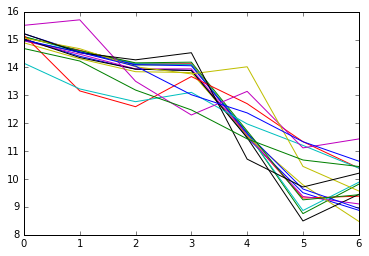

In [1214]:
plt.plot(np.sum(ch_dists[3:],axis=1))
plt.show()
plt.plot(ch_dists[3:])

In [63]:
all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

test_weights=[v for v in all_vars \
 if v.name == 'Conv/weights:0'][0]\
.eval(session=sess)

np.std(test_weights[:,:,:,:16])

0.047995478

(array([  2.59428400e-06,   5.96685321e-05,   2.77588388e-04,
          1.65255891e-03,   1.15731009e-02,   9.99650007e+00,
          7.09116401e-01,   1.78673528e-01,   1.03268069e-01,
          7.80386571e-02,   6.30877984e-02,   4.95145045e-02,
          3.84862032e-02,   3.03842543e-02,   2.39789671e-02,
          1.85828563e-02,   1.41258764e-02,   9.50805088e-03,
          6.12769882e-03,   3.52044339e-03,   1.79524453e-03,
          7.54936645e-04,   3.29474069e-04,   1.76411312e-04,
          6.48571001e-05,   2.33485560e-05,   7.78285201e-06,
          0.00000000e+00,   2.59428400e-06,   2.59428400e-06]),
 array([-0.49424896, -0.40606271, -0.31787645, -0.2296902 , -0.14150395,
        -0.0533177 ,  0.03486855,  0.1230548 ,  0.21124105,  0.2994273 ,
         0.38761355,  0.47579981,  0.56398606,  0.65217231,  0.74035856,
         0.82854481,  0.91673106,  1.00491731,  1.09310356,  1.18128981,
         1.26947607,  1.35766232,  1.44584857,  1.53403482,  1.62222107,
         1.71

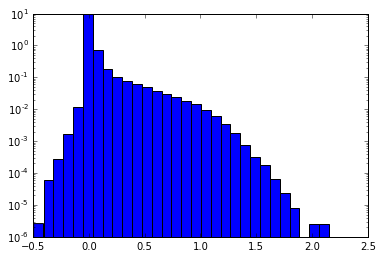

In [206]:
plt.hist(Qpred_list,log=True,normed=True,bins=30)

In [207]:
avg_reward = np.mean([e[2] for e in myBuffer.buffer])
avg_stable_q = avg_reward / (1-y)
print avg_stable_q

0.02448


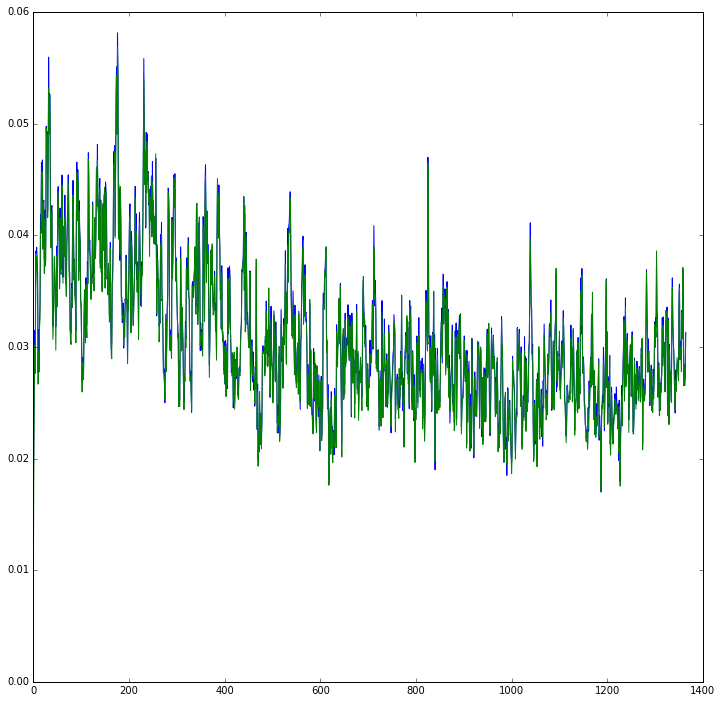

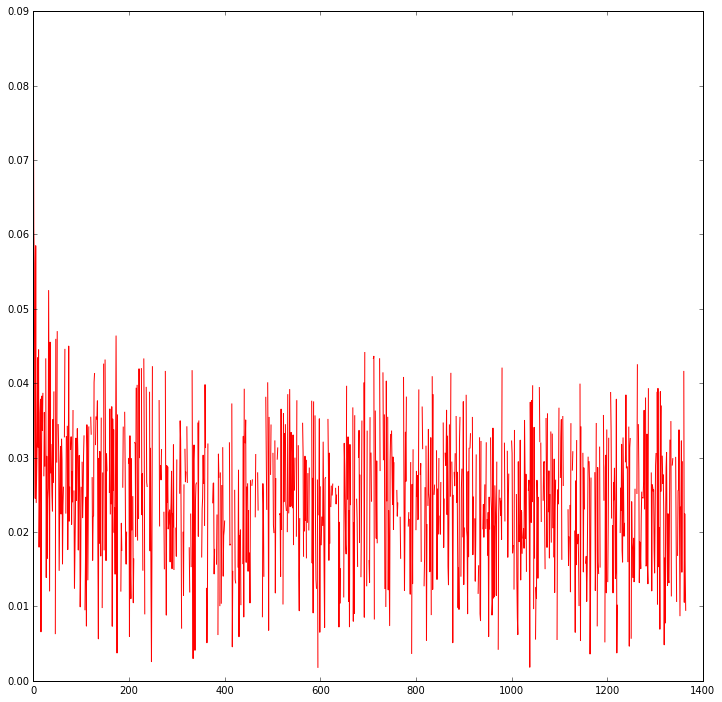

In [210]:
sync_length = min(len(Qpred_list), len(Qtarget_list))
Qpred_list = Qpred_list[:sync_length]
Qtarget_list = Qtarget_list[:sync_length]

avg_window = 32*100

plt.figure(figsize=(12,12))
QtMat = np.resize(np.array(Qtarget_list),[len(Qtarget_list)//avg_window,avg_window])
QtAvgs = np.average(QtMat,1)
plt.plot(QtAvgs)

QpMat = np.resize(np.array(Qpred_list),[len(Qpred_list)//avg_window,avg_window])
QpAvgs = np.average(QpMat,1)
plt.plot(QpAvgs)

plt.figure(figsize=(12,12))
losses = np.array(Qtarget_list)-np.array(Qpred_list)
lossMat = np.resize(losses,[len(losses)//avg_window,avg_window])
lossAvgs = np.sqrt(np.average(lossMat,1))
plt.plot(lossAvgs,'r')

In [840]:
len(Qtarget_list)

380832

[[ 1.          0.91082174]
 [ 0.91082174  1.        ]]


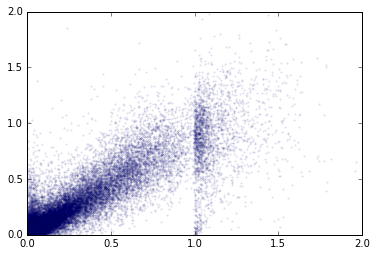

In [841]:
plt.plot(Qtarget_list,Qpred_list,'o',markersize=1.5,alpha=0.1)
plt.axis([0,2,0,2])
print np.corrcoef(Qtarget_list,Qpred_list)

In [843]:
cols = []
Qpred_list = np.array(Qpred_list)
rOptions = np.unique(QrList)
for r in rOptions:
    cols.append(Qpred_list[QrList==r])

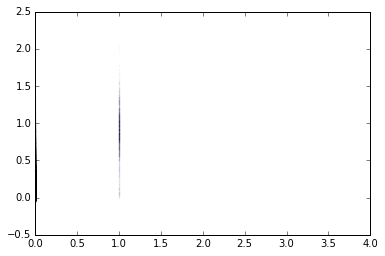

In [844]:
plt.plot(QrList,Qpred_list,'o',markersize=1,alpha=0.01)

In [845]:
buffer_all = np.array(myBuffer.buffer)
(buffer_all[:,2]>0).mean()

0.0058999999999999999

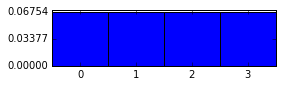

In [112]:
plt.figure(figsize=(4,1))
plt.bar(np.arange(4)-0.5,Qout,width=1)
plt.xticks(range(4));
plt.yticks(np.linspace(0,max(Qout),3));

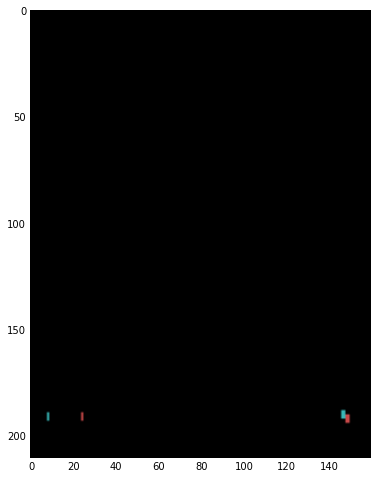

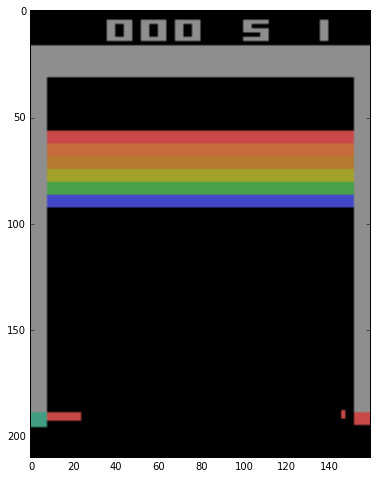

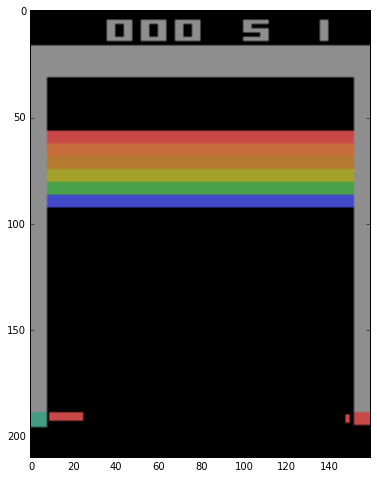

In [901]:
plt.figure(figsize=(12,8))
plt.imshow(s_stack[:,:,3:]-s_stack[:,:,:3])
plt.figure(figsize=(12,8))
plt.imshow(s_stack[:,:,:3])
plt.figure(figsize=(12,8))

plt.imshow(s_stack[:,:,3:])

In [902]:
sess.run(mainQN.conv2,feed_dict={mainQN.scalarInput:[s]})

array([[[[-0.00875617, -0.01546426, -0.00618444, -0.00656676, -0.00902274,
          -0.02128692, -0.01523175,  0.11306629]]]], dtype=float32)

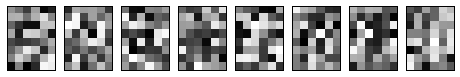

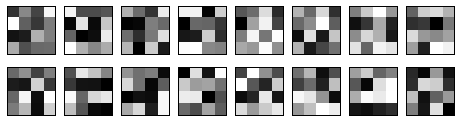

In [147]:
all_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

#test_kernel=[v for v in all_vars \
# if v.name == 'mainQN/piaget/mover_disps/mover0/disp2/kernel:0'][0]\
#.eval(session=sess)

test_weights=[v for v in all_vars \
 if v.name == 'Conv/weights:0'][0]\
.eval(session=sess)

q_weights=[v for v in all_vars \
 if v.name == 'Conv_1/weights:0'][0]\
.eval(session=sess)

i_max=1
j_max=8
plt.figure(figsize=(8,2))
for i in range(i_max):
    for j in range(j_max):
        cmap_max = max(np.max(q_weights[:,:,i,j]),
                      -np.min(q_weights[:,:,i,j]))
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(q_weights[:,:,i,j],cmap='gray',
        interpolation='nearest',
        vmin=-cmap_max,vmax=cmap_max)
plt.show()

i_max=2
j_max=8
plt.figure(figsize=(8,2))
for i in range(i_max):
    for j in range(j_max):
        cmap_max = max(np.max(test_weights[:,:,j+(i*j_max),0]),
                      -np.min(test_weights[:,:,j+(i*j_max),0]))
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(test_weights[:,:,j+(i*j_max),0],cmap='gray',
        interpolation='nearest',
                  vmin=-cmap_max,vmax=cmap_max)
plt.show()

In [144]:
plt.axis?

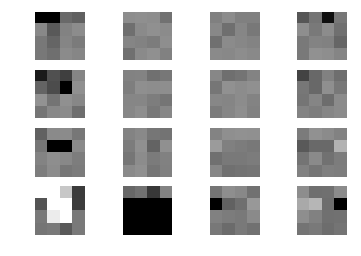

In [904]:
test_weights.shape
i_max=4
j_max=4
for i in range(i_max):
    for j in range(j_max):
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.axis('off')
        plt.imshow(test_weights[:,:,j+(i*j_max),0],cmap='gray',
        interpolation='nearest',
                  vmin=-1,vmax=1)

In [905]:
#c0=sess.run(mainQN.conv_movers,feed_dict={mainQN.scalarInput:[s]})
c1=sess.run(mainQN.conv_dm_pool,feed_dict={mainQN.scalarInput:[s]})
c2=sess.run(mainQN.conv1_pool,feed_dict={mainQN.scalarInput:[s]})
c3=sess.run(mainQN.conv2,feed_dict={mainQN.scalarInput:[s]})

In [906]:
print c1.shape
print c2.shape
print c3.shape

(1, 52, 40, 16)
(1, 8, 6, 4)
(1, 1, 1, 8)


In [907]:
[[mover_disps[0][j],np.max(c1[0,:,:,j])] for j in range(10)]

IndexError: list index out of range

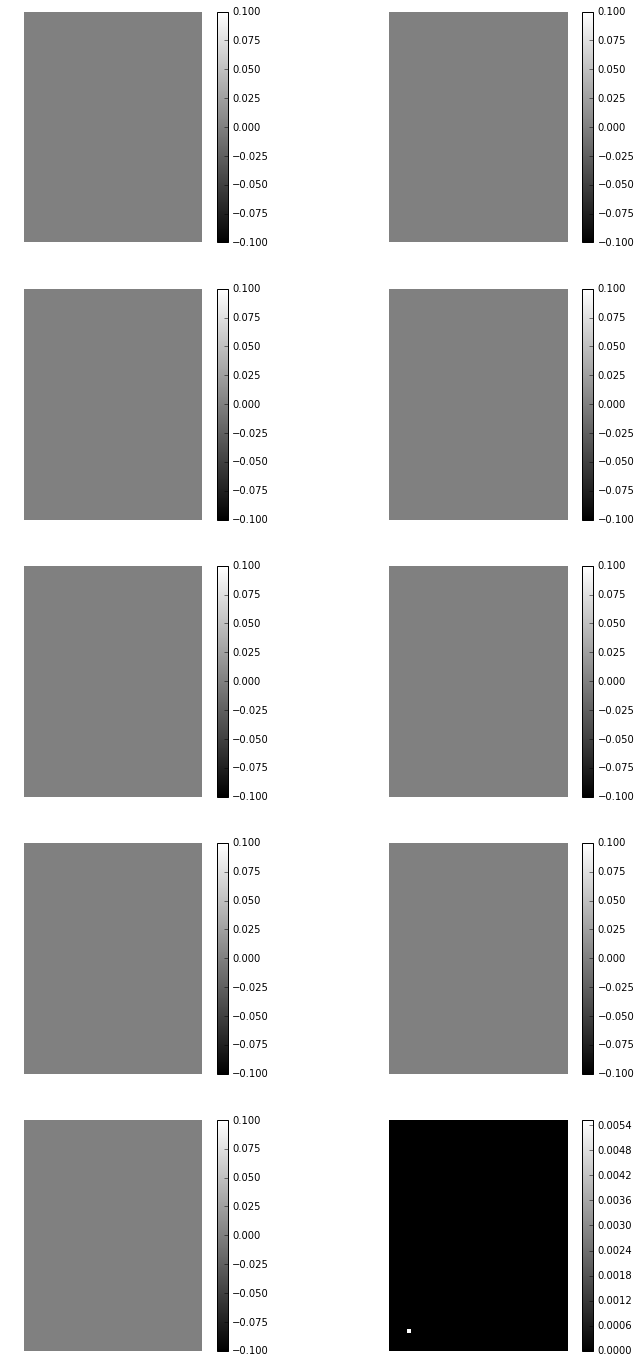

In [908]:
plt.figure(figsize=(12,24))
i_max=5
j_max=2
for i in range(i_max):
    for j in range(j_max):
        plt.subplot(i_max,j_max,j+(i*j_max)+1)
        plt.axis('off')
        im = c1[0,:,:,j+(i*j_max)]
        plt.imshow(im,cmap='gray',
        interpolation='nearest')
        plt.colorbar()

In [ ]:
[(i, np.max(c3[0,:,:,i])) for i in range(16)]

In [602]:
test = reduce(lambda a,b: a+b, mover_disps)
test[8]

(-2, 2)

In [603]:
for index in range(16):
    #print(test[index])
    plt.figure(figsize=(12,8))
    plt.imshow(c1[0,:,:,3]-c0[0,:,:,2],interpolation='nearest')
    plt.colorbar()
    plt.figure(figsize=(6,4))
    plt.imshow(c3[0,:,:,index],interpolation='nearest')
    plt.colorbar()

NameError: name 'c0' is not defined

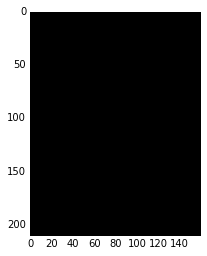

In [971]:
plt.imshow(s_stack[:,:,3:]-s_stack[:,:,:3])

### Checking network learning

Mean reward over time

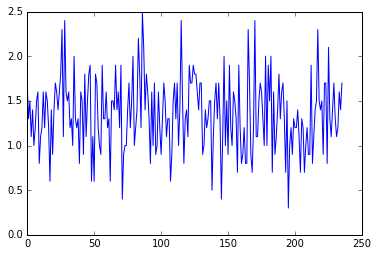

In [205]:
rMat = np.resize(np.array(rList),[len(rList)//10,10])
rMean = np.average(rMat,1)
plt.plot(rMean)